# RBC and MPC Simulation DRH and IFH Real Data

This notebook contains simulations for the DRH MPC suystem that will be used throughout thesis

In [699]:
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.dae import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import pymysql
import datetime
#from datetime import datetime
import time
from sklearn.metrics import mean_squared_error

## Importing Data

**Specify start and end date of MPC simulations**

In [700]:
start = '2020-11-3'
end = '2020-11-4'
#end = '2020-12-4'
dt = 1/3
sim = 'DRH'

#sb_phase = 'P1'

In [701]:
sim_start = 0
sim_end = 2200

**Import fixed time series data**

In [706]:
sbrc = pd.read_csv('CSV/SBRC Incomer - Hioki PW3198 30sec 20201020 to 20201124.CSV')
sbrc.index = pd.to_datetime((sbrc['Date']+' '+sbrc['Time']), format='%Y/%m/%d %H:%M:%S')

In [707]:
pv = pd.read_csv('CSV/SBRC Office PV - Hioki PW3360 30sec 20201023 to 20201213.CSV', skiprows=16)
pv = pv.drop(pv.index[0])
pv['Date'] = [idx+':00' if i%2==0 else idx+':30' for i,idx in enumerate(pv['Date'])]
pv.index = pd.to_datetime((pv['Date']), format='%d/%m/%Y %H:%M:%S')

In [708]:
ts_data.columns

Index(['fixed', 'tou', 'fit', 'ch_cost', 'dis_cost', 'mode_0', 'mode_1',
       'mode_2', 'set_point', 'sp_soft', 'heat_gains', 'load_sim', 'load1',
       'heat_gains0', 'load'],
      dtype='object')

In [709]:
if(sim=='DRH'):
    power_balance['pv'] = (power_balance['pv_master'] + power_balance['pv_slave'])
elif(sim=='IFH'):
    power_balance['pv'] = -ifh.loc[start:end]['AvgP2']

<AxesSubplot:>

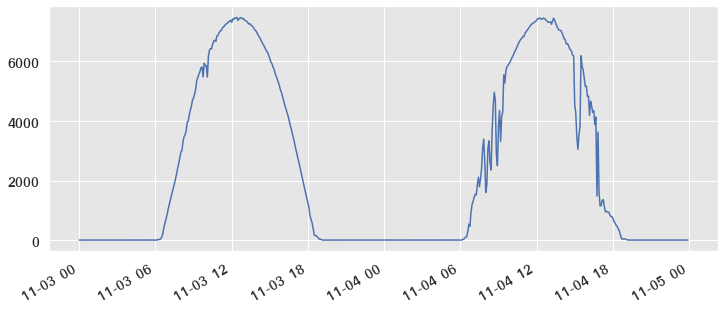

In [710]:
(power_balance['pv_master'] + power_balance['pv_slave']).plot()

**Build dataframe with all relevant data source to use in simulations**

In [711]:
#Join weather and power data frames
sim_data = weather.join(power_balance['pv'], how='inner')

In [712]:
#insert fixed time series data into df
for col in ts_data.columns:
    sim_data[col] = [ts_data[col].loc[idx]  for idx in sim_data.index.time]

In [713]:
sim_data['t_ext'] = sim_data['t_ext'].ewm(span = 24).mean()

In [714]:
m_cool, b_cool = np.polyfit(x=[20,25,30,35,40,45], y=[-10.24, -9.38, -8.41, -7.44, -5.16, -3.79], deg=1)

In [715]:
m_cop, b_cop = np.polyfit(x=[20,25,30,35,40,45], y=[3.59, 3.26, 2.85, 2.44, 2.15, 1.88], deg=1)

In [716]:
sim_data['cop'] = m_cop*(sim_data['t_ext']) + b_cop
sim_data['cool_cap'] = m_cool*sim_data['t_ext'] + b_cool

In [717]:
states = {'SoC_Av':20,
         'T_i': 24,
         'T_w': 23,
         'phi_h':0,
         'phi_c':0}

## DRH MPC Formulation

In [718]:
class MPC_DRH():
    def __init__(self, **kwargs):
        self.Np = kwargs.get('Np', None)
        self.dt = kwargs.get('dt', None)
        self.forecasts = kwargs.get('forecasts', None)
        self.states = kwargs.get('states', None)
        self.n_ch = 0.96
        self.n_dis = 0.98
        self.max_soc = 13.8
        self.min_soc = 0
        self.max_ch = 3000
        self.max_dis = 3000
        self.batt_cost = 0.01
        self.M = 1000000
        self.R_w = 2.786
        self.C_w = 14.78
        self.C_i = 1.887
#         self.C_w = 1.78
#         self.C_i = 30.887
        self.A_g = 0.637
        self.A_w = 2.103
        self.COP = 3.69
        self.n_hvac = 0.6
        self.T_in_min = 16
        self.T_in_max = 50
        self.heat_cap = 7.4
        #self.cool_cap = 6.2
        self.min_cool = 1.8
        self.hp_rated_p = 8000
        self.hp_min_p = 1000
        self.weighted_batt = (np.arange(len(self.forecasts.index))/1000000) + self.batt_cost
        self.m = ConcreteModel()
        self.solver = SolverFactory('gurobi_ampl')
        self.control_modes = {}

    def initaliseSets(self):
        #time = list(range(int(self.Np/self.dt)))
        time = np.arange(len(self.forecasts.index))
        time_str = [str(x) for x in time]
        self.m.t = ContinuousSet(initialize=time)

    def initaliseScalars(self):
        #Initialise Electrical scalars
        #self.m.soc0 = Param(initialize=((self.states['SoC_Av']/100.0)*self.max_soc))
        self.m.soc0 = Param(initialize=self.states['SoC_Av'])
        self.m.dt = Param(initialize=self.dt)
        self.m.n_ch = Param(initialize=self.n_ch)
        self.m.n_dis = Param(initialize=self.n_dis)
        
        
        #Initialise thermal
        self.m.R_w = Param(initialize=self.R_w)
        self.m.C_w = Param(initialize=self.C_w)
        self.m.C_i = Param(initialize=self.C_i)
        self.m.A_g = Param(initialize=self.A_g)
        self.m.A_w = Param(initialize=self.A_w)
        self.m.COP = Param(initialize=self.COP)
        self.m.n_hvac = Param(initialize=self.n_hvac)

    def initialiseParameters(self):
        #Initialise Electrical Parameters
        self.m.p_load = Param(self.m.t, initialize=self.forecasts['load'].iloc[0], mutable=True)
        self.m.p_pv = Param(self.m.t, initialize=self.forecasts['pv'].iloc[0], mutable=True)
        self.m.tou = Param(self.m.t, initialize=self.forecasts['tou'].iloc[0], mutable=True)
        self.m.fit = Param(self.m.t, initialize=self.forecasts['fit'].iloc[0], mutable=True)
        self.m.batt_cost = Param(self.m.t, initialize=self.weighted_batt[0], mutable=True)
        self.m.ch_cost = Param(self.m.t, initialize=self.forecasts['ch_cost'].iloc[0], mutable=True)
        self.m.dis_cost = Param(self.m.t, initialize=self.forecasts['dis_cost'].iloc[0], mutable=True)
        self.m.mode_0 = Param(self.m.t, initialize=self.forecasts['mode_0'].iloc[0], mutable=True)
        self.m.mode_1 = Param(self.m.t, initialize=self.forecasts['mode_1'].iloc[0], mutable=True)
        
        
        
        #Initialise Paramerters
        self.m.ghi = Param(self.m.t, initialize=self.forecasts['ghi'].iloc[0]/1000, mutable=True)
        self.m.T_a = Param(self.m.t, initialize=self.forecasts['t_ext'].iloc[0], mutable=True)
        self.m.phi_g = Param(self.m.t, initialize=self.forecasts['heat_gains'].iloc[0], mutable=True)
        self.m.T_set = Param(self.m.t, initialize=self.forecasts['set_point'].iloc[0], mutable=True)
        self.m.T_set_cost = Param(self.m.t, initialize=self.forecasts['sp_soft'].iloc[0], mutable=True)
        self.m.cop = Param(self.m.t, initialize=self.forecasts['cop'].iloc[0], mutable=True)
        self.m.cool_cap = Param(self.m.t, initialize=self.forecasts['cool_cap'].iloc[0], mutable=True)

        #Insert predicted data into model
        weight = 0

        for n, time in enumerate(self.forecasts.index):
            #Electrical
            self.m.p_load[n] = self.forecasts['load'].loc[time]
            self.m.p_pv[n] = self.forecasts['pv'].loc[time]
            self.m.tou[n]= self.forecasts['tou'].loc[time]
            self.m.fit[n] = self.forecasts['fit'].loc[time]
            self.m.batt_cost[n]= self.weighted_batt[n]
            #self.m.batt_cost[n]= 0.01+weight
            self.m.ch_cost[n] = self.forecasts['ch_cost'].loc[time]
            self.m.dis_cost[n] = self.forecasts['dis_cost'].loc[time]
            self.m.mode_0[n] = self.forecasts['mode_0'].loc[time]
            self.m.mode_1[n] = self.forecasts['mode_1'].loc[time]
            #Thermal
            self.m.T_a[n].value = self.forecasts['t_ext'].loc[time]
            self.m.ghi[n].value = self.forecasts['ghi'].loc[time]/1000
            self.m.phi_g[n].value = self.forecasts['heat_gains'].loc[time]
            self.m.T_set[n].value = self.forecasts['set_point'].loc[time]
            self.m.T_set_cost[n].value = self.forecasts['sp_soft'].loc[time]
            self.m.cop[n].value = self.forecasts['cop'].loc[time]
            self.m.cool_cap[n].value = self.forecasts['cool_cap'].loc[time]
            
            weight = (weight + n/100000)

    def initaliseVariables(self):
        #initialise electrical variables
        self.m.p_im = Var(self.m.t, bounds=(0.0,None), doc='Power imported from grid')
        self.m.p_ex = Var(self.m.t, bounds=(None,0.0), doc='Power exported to grid')
        self.m.p_ch = Var(self.m.t, bounds=(-self.max_ch,0.0), doc='batt charge power')
        self.m.p_ch_p = Var(self.m.t, bounds=(-self.max_ch,0.0), doc='batt charge power')
        self.m.p_ch_g = Var(self.m.t, bounds=(-500,0.0), doc='batt charge power')
        self.m.p_dis = Var(self.m.t, bounds=(0.0,self.max_dis), doc='batt dis power')
        self.m.soc = Var(self.m.t, bounds=(0,100), doc='batt soc')
        #self.m.p_hvac = Var(self.m.t, bounds=(0.0,self.hp_rated_p), doc='hvac power')
        self.m.p_hvac = Var(self.m.t, bounds=(0, self.hp_rated_p), doc='hvac power')
        
        #Initialise Thermal Variables
        #self.m.T_i = Var(self.m.t, bounds=(self.T_in_min,self.T_in_max))
        self.m.T_i = Var(self.m.t, bounds=self.set_point_bounds)
        self.m.T_w = Var(self.m.t,bounds=(-10,60.0))
        #self.m.phi_h_heat = Var(self.m.t, bounds=(0.0,self.heat_cap))
        self.m.phi_h_cool = Var(self.m.t, bounds=self.cool_cap_bounds)
        #self.m.phi_h_cool = Var(self.m.t, bounds=(-10,0))
        
        self.m.hp_switch = Var(self.m.t, bounds=(self.hp_min_p,self.hp_rated_p))
        self.m.dhp = Var(self.m.t, within=Binary)

        #Initialise Binary Variables
        self.m.dbatt = Var(self.m.t, within=Binary)
        self.m.dhvac = Var(self.m.t, within=Binary)
        
        #Initialise derivatives
        self.m.dT_i = DerivativeVar(self.m.T_i, wrt=self.m.t)
        self.m.dT_w = DerivativeVar(self.m.T_w, wrt=self.m.t)

    def initialseConstraints(self):
        
        self.m.state = Constraint(self.m.t, rule=self.state_of_charge)
        self.m.powBal = Constraint(self.m.t, rule=self.powerBalance, doc='Power balance equation')

        self.m.charge_balance = Constraint(self.m.t, rule=self.chargeBalance)
        self.m.pv_charge = Constraint(self.m.t, rule=self.pvCharge)

        self.m.binary_discharge = Constraint(self.m.t, rule=self.binaryDischarge)
        self.m.binary_charge = Constraint(self.m.t, rule=self.binaryCharge)
        
        self.m.de1 = Constraint(self.m.t, rule=self.T_i_dot)
        self.m.de2 = Constraint(self.m.t, rule=self.T_w_dot)
        
        self.m.heatpump = Constraint(self.m.t, rule=self.heatpump_rule)
#         self.m.heat_min = Constraint(self.m.t, rule=self.hp_min)
#         self.m.heat_max = Constraint(self.m.t, rule=self.hp_max)
        
#         self.m.binary_heat = Constraint(self.m.t, rule=self.binaryHeat)
#         self.m.binary_cool = Constraint(self.m.t, rule=self.binaryCool)
        
        self.m.init_conditions = ConstraintList(rule=self._init)

        self.m.obj = Objective(rule=self.objFunc, sense=minimize)
        
      #------------------------Thermal----------------------#  

    #COOLING and HEATING CONTRAINTS
    def T_i_dot(self, m, t):
        #return m.dT_i[t] == (1/(m.R_w*m.C_i))*(m.T_w[t] - m.T_i[t]) + (m.phi_g[t]/m.C_i) + ((m.phi_h_heat[t]+m.phi_h_cool[t])/m.C_i) + ((m.A_g*m.ghi[t])/m.C_i)
        #return m.dT_i[t] == ((1/(m.R_w*m.C_i))*(m.T_w[t] - m.T_i[t]) + (m.phi_g[t]/m.C_i) + ((m.phi_h_heat[t]+m.phi_h_cool[t])/m.C_i) + ((m.A_g*m.ghi[t])/m.C_i))*self.dt
        return m.dT_i[t] == ((1/(m.R_w*m.C_i))*(m.T_w[t] - m.T_i[t]) + (m.phi_g[t]/m.C_i) + ((m.phi_h_cool[t])/m.C_i) + ((m.A_g*m.ghi[t])/m.C_i))*self.dt
    
    #First order DE 2
    def T_w_dot(self, m, t):
        #return m.dT_w[t] == (1/(m.R_w*m.C_w))*(m.T_i[t] - m.T_w[t]) + (1/(m.R_w*m.C_w))*(m.T_a[t] - m.T_w[t]) + ((m.A_w*m.ghi[t])/m.C_w)
        return m.dT_w[t] == ((1/(m.R_w*m.C_w))*(m.T_i[t] - m.T_w[t]) + (1/(m.R_w*m.C_w))*(m.T_a[t] - m.T_w[t]) + ((m.A_w*m.ghi[t])/m.C_w))*self.dt
        
    
    #HVAc heat pump model
    def heatpump_rule(self, m,t):
        #return (m.p_hvac[t]/1000)*m.n_hvac*m.cop[t] == ((m.phi_h_heat[t]) - (m.phi_h_cool[t]))
        return (m.p_hvac[t]/1000)*m.n_hvac*m.cop[t] == -(m.phi_h_cool[t])
        #return (m.p_hvac[t]/1000)*m.n_hvac*m.COP == ((m.phi_h_heat[t]) - (m.phi_h_cool[t]))
    
    
    def binaryHeat(self, m,t):
        return -m.phi_h_cool[t] <= self.M*self.m.dhvac[t]
    
    def binaryCool(self, m,t):
        return m.phi_h_heat[t] <= self.M*(1-self.m.dhvac[t])
    
    def cool_cap_bounds(self, m, t):
        return (self.m.cool_cap[t],0)
    
    
    def hp_min(self, m, t):
        return m.p_hvac[t] >= self.hp_min_p*self.m.dhp[t]
        #return -m.phi_h_cool[t] >= self.min_cool*self.m.dhp[t]
    
    def hp_max(self, m, t):
        return m.p_hvac[t] <= self.M*self.m.dhp[t]
        #return -m.phi_h_cool[t] <= -self.m.cool_cap[t]*self.m.dhp[t]

    
    def set_point_bounds(self, m, t):
        #return (self.m.T_set[t]-0.5, self.m.T_set[t]+0.5)
        return (21, 27)
        #return (23, 26)
    
    
    #------------------------Electrical----------------------#
    
    def state_of_charge(self, m,t):
        j = list(range(t+1))
        return self.m.soc0 + sum(-((((self.m.p_ch[i]*self.m.n_ch)+(self.m.p_dis[i]/self.m.n_dis))*(self.m.dt/1000))/self.max_soc)*100 for i in j) == self.m.soc[t]


    def powerBalance(self, m,t):
        return (self.m.p_load[t] + self.m.p_hvac[t])-self.m.p_pv[t]-(self.m.p_ch[t])-self.m.p_im[t]-self.m.p_ex[t]-(self.m.p_dis[t])  == 0.0
        #return (self.m.p_load[t])-self.m.p_pv[t]-(self.m.p_ch[t])-self.m.p_im[t]-self.m.p_ex[t]-(self.m.p_dis[t])  == 0.0

        
    def chargeBalance(self, m,t):
        return self.m.p_ch[t] == self.m.p_ch_p[t] + self.m.p_ch_g[t]

    def pvCharge(self, m,t):
        return self.m.p_ch_p[t] >= -self.m.p_pv[t]


    def binaryDischarge(self, m,t):
        return self.m.p_dis[t] <= self.M*self.m.dbatt[t]

    def binaryCharge(self, m,t):
        return -self.m.p_ch[t] <= self.M*(1-self.m.dbatt[t])
    

    
    #State measurements
    def _init(self, m):
        yield m.T_i[0] == self.states['T_i']
        yield m.T_w[m.t.first()] == self.states['T_w']
        #yield m.phi_h_heat[m.t.first()] == self.states['phi_h']
        yield m.phi_h_cool[m.t.first()] == self.states['phi_c']


    #Combined Objective function - linear p_ch_g
    
    def objFunc(self, m):  
        
        return sum(self.m.mode_0[t]*((self.m.p_im[t]*(self.m.dt)*self.m.tou[t])
                   + (self.m.p_ex[t]*(self.m.dt)*self.m.fit[t])
                   + (-self.m.p_ch_p[t]*(self.m.dt)*self.m.batt_cost[t])
                   + (self.m.p_dis[t]*(self.m.dt)*self.m.batt_cost[t])
                   + (-(self.m.p_ch_g[t])*(self.m.dt)*(self.m.ch_cost[t]))
                   + (self.m.T_set_cost[t]*((self.m.T_i[t] - self.m.T_set[t])*(self.m.T_i[t] - self.m.T_set[t])))
                   + 0.25*(self.m.p_hvac[t]*(self.m.dt)))
                   + self.m.mode_1[t]*((self.m.p_ex[t] - 0)*(self.m.p_ex[t] - 0))
                   for t in self.m.t)

    
#     def objFunc(self, m):  
        
#         return sum(self.m.mode_0[t]*((self.m.p_im[t]*(self.m.dt)*self.m.tou[t])
#                    + (self.m.p_ex[t]*(self.m.dt)*self.m.fit[t])
#                    + (-self.m.p_ch_p[t]*(self.m.dt)*self.m.batt_cost[t])
#                    + (-(self.m.p_ch_g[t])*(self.m.dt)*(self.m.ch_cost[t]))
#                    + (self.m.p_dis[t]*(self.m.dt)*self.m.batt_cost[t]))
#                    + self.m.mode_1[t]*((self.m.p_ex[t] - 0)*(self.m.p_ex[t] - 0))
#                    for t in self.m.t)
    

    
        
    

#     def objFunc(self, m):  
        
#         return sum(self.m.mode_0[t]*((self.m.p_im[t]*(self.m.dt)*self.m.tou[t])
#                    + (self.m.p_ex[t]*(self.m.dt)*self.m.fit[t])
#                    + (-self.m.p_ch_p[t]*(self.m.dt)*self.m.batt_cost[t])
#                    + (self.m.p_dis[t]*(self.m.dt)*self.m.batt_cost[t])
#                    + (-(self.m.p_ch_g[t])*(self.m.dt)*(self.m.ch_cost[t])))
#                    for t in self.m.t)
    


    
    def solve(self):
        
        self.initaliseSets()
        self.initaliseScalars()
        self.initialiseParameters()
        self.initaliseVariables()
        self.initialseConstraints()
        
        #Discretise the model
        discretizer = TransformationFactory('dae.finite_difference')
        discretizer.apply_to(self.m, nfe=48, wrt=self.m.t, scheme='BACKWARD')
        
        solver = SolverFactory('gurobi_ampl')
        results = solver.solve(self.m, keepfiles=True, tee=True)
        
        return results


# IFH MPC Formulation

In [719]:
class MPC_IFH():
    def __init__(self, **kwargs):
        self.Np = kwargs.get('Np', None)
        self.dt = kwargs.get('dt', None)
        self.forecasts = kwargs.get('forecasts', None)
        self.states = kwargs.get('states', None)
        self.n_ch = 0.96
        self.n_dis = 0.98
        self.max_soc = 8.8
        self.min_soc = 0
        self.max_ch = 7500
        self.max_dis = 7500
        self.batt_cost = 0.01
        self.M = 1000000
        self.R_w = 6.54
        self.C_w = 6.72
        self.C_i = 3.39
#         self.C_w = 1.78
#         self.C_i = 30.887
        self.A_g = 1.15
        self.A_w = 2.91
        self.COP = 3.6
        self.n_hvac = 0.6
        self.T_in_min = 16
        self.T_in_max = 50
        self.heat_cap = 7.4
        #self.cool_cap = 6.2
        self.min_cool = 1.8
        self.hp_rated_p = 8000
        self.hp_min_p = 1000
        self.weighted_batt = (np.arange(len(self.forecasts.index))/1000000) + self.batt_cost
        self.m = ConcreteModel()
        self.solver = SolverFactory('gurobi_ampl')
        self.control_modes = {}

    def initaliseSets(self):
        #time = list(range(int(self.Np/self.dt)))
        time = np.arange(len(self.forecasts.index))
        time_str = [str(x) for x in time]
        self.m.t = ContinuousSet(initialize=time)

    def initaliseScalars(self):
        #Initialise Electrical scalars
        #self.m.soc0 = Param(initialize=((self.states['SoC_Av']/100.0)*self.max_soc))
        self.m.soc0 = Param(initialize=self.states['SoC_Av'])
        self.m.dt = Param(initialize=self.dt)
        self.m.n_ch = Param(initialize=self.n_ch)
        self.m.n_dis = Param(initialize=self.n_dis)
        
        
        #Initialise thermal
        self.m.R_w = Param(initialize=self.R_w)
        self.m.C_w = Param(initialize=self.C_w)
        self.m.C_i = Param(initialize=self.C_i)
        self.m.A_g = Param(initialize=self.A_g)
        self.m.A_w = Param(initialize=self.A_w)
        self.m.COP = Param(initialize=self.COP)
        self.m.n_hvac = Param(initialize=self.n_hvac)

    def initialiseParameters(self):
        #Initialise Electrical Parameters
        self.m.p_load = Param(self.m.t, initialize=self.forecasts['load'].iloc[0], mutable=True)
        self.m.p_pv = Param(self.m.t, initialize=self.forecasts['pv'].iloc[0], mutable=True)
        self.m.tou = Param(self.m.t, initialize=self.forecasts['tou'].iloc[0], mutable=True)
        self.m.fit = Param(self.m.t, initialize=self.forecasts['fit'].iloc[0], mutable=True)
        self.m.batt_cost = Param(self.m.t, initialize=self.weighted_batt[0], mutable=True)
        self.m.ch_cost = Param(self.m.t, initialize=self.forecasts['ch_cost'].iloc[0], mutable=True)
        self.m.dis_cost = Param(self.m.t, initialize=self.forecasts['dis_cost'].iloc[0], mutable=True)
        self.m.mode_0 = Param(self.m.t, initialize=self.forecasts['mode_0'].iloc[0], mutable=True)
        self.m.mode_1 = Param(self.m.t, initialize=self.forecasts['mode_1'].iloc[0], mutable=True)
        
        
        
        #Initialise Paramerters
        self.m.ghi = Param(self.m.t, initialize=self.forecasts['ghi'].iloc[0]/1000, mutable=True)
        self.m.T_a = Param(self.m.t, initialize=self.forecasts['t_ext'].iloc[0], mutable=True)
        self.m.phi_g = Param(self.m.t, initialize=self.forecasts['heat_gains'].iloc[0], mutable=True)
        self.m.T_set = Param(self.m.t, initialize=self.forecasts['set_point'].iloc[0], mutable=True)
        self.m.T_set_cost = Param(self.m.t, initialize=self.forecasts['sp_soft'].iloc[0], mutable=True)
        self.m.cop = Param(self.m.t, initialize=self.forecasts['cop'].iloc[0], mutable=True)
        self.m.cool_cap = Param(self.m.t, initialize=self.forecasts['cool_cap'].iloc[0], mutable=True)

        #Insert predicted data into model
        weight = 0

        for n, time in enumerate(self.forecasts.index):
            #Electrical
            self.m.p_load[n] = self.forecasts['load'].loc[time]
            self.m.p_pv[n] = self.forecasts['pv'].loc[time]
            self.m.tou[n]= self.forecasts['tou'].loc[time]
            self.m.fit[n] = self.forecasts['fit'].loc[time]
            self.m.batt_cost[n]= self.weighted_batt[n]
            #self.m.batt_cost[n]= 0.01+weight
            self.m.ch_cost[n] = self.forecasts['ch_cost'].loc[time]
            self.m.dis_cost[n] = self.forecasts['dis_cost'].loc[time]
            self.m.mode_0[n] = self.forecasts['mode_0'].loc[time]
            self.m.mode_1[n] = self.forecasts['mode_1'].loc[time]
            #Thermal
            self.m.T_a[n].value = self.forecasts['t_ext'].loc[time]
            self.m.ghi[n].value = self.forecasts['ghi'].loc[time]/1000
            self.m.phi_g[n].value = self.forecasts['heat_gains'].loc[time]
            self.m.T_set[n].value = self.forecasts['set_point'].loc[time]
            self.m.T_set_cost[n].value = self.forecasts['sp_soft'].loc[time]
            self.m.cop[n].value = self.forecasts['cop'].loc[time]
            self.m.cool_cap[n].value = self.forecasts['cool_cap'].loc[time]
            
            weight = (weight + n/100000)

    def initaliseVariables(self):
        #initialise electrical variables
        self.m.p_im = Var(self.m.t, bounds=(0.0,None), doc='Power imported from grid')
        self.m.p_ex = Var(self.m.t, bounds=(None,0.0), doc='Power exported to grid')
        self.m.p_ch = Var(self.m.t, bounds=(-self.max_ch,0.0), doc='batt charge power')
        self.m.p_ch_p = Var(self.m.t, bounds=(-self.max_ch,0.0), doc='batt charge power')
        self.m.p_ch_g = Var(self.m.t, bounds=(-500,0.0), doc='batt charge power')
        self.m.p_dis = Var(self.m.t, bounds=(0.0,self.max_dis), doc='batt dis power')
        self.m.soc = Var(self.m.t, bounds=(0,100), doc='batt soc')
        #self.m.p_hvac = Var(self.m.t, bounds=(0.0,self.hp_rated_p), doc='hvac power')
        self.m.p_hvac = Var(self.m.t, bounds=(0, self.hp_rated_p), doc='hvac power')
        
        #Initialise Thermal Variables
        #self.m.T_i = Var(self.m.t, bounds=(self.T_in_min,self.T_in_max))
        self.m.T_i = Var(self.m.t, bounds=self.set_point_bounds)
        self.m.T_w = Var(self.m.t,bounds=(-10,60.0))
        #self.m.phi_h_heat = Var(self.m.t, bounds=(0.0,self.heat_cap))
        self.m.phi_h_cool = Var(self.m.t, bounds=self.cool_cap_bounds)
        #self.m.phi_h_cool = Var(self.m.t, bounds=(-10,0))
        
        self.m.hp_switch = Var(self.m.t, bounds=(self.hp_min_p,self.hp_rated_p))
        self.m.dhp = Var(self.m.t, within=Binary)

        #Initialise Binary Variables
        self.m.dbatt = Var(self.m.t, within=Binary)
        self.m.dhvac = Var(self.m.t, within=Binary)
        
        #Initialise derivatives
        self.m.dT_i = DerivativeVar(self.m.T_i, wrt=self.m.t)
        self.m.dT_w = DerivativeVar(self.m.T_w, wrt=self.m.t)

    def initialseConstraints(self):
        
        self.m.state = Constraint(self.m.t, rule=self.state_of_charge)
        self.m.powBal = Constraint(self.m.t, rule=self.powerBalance, doc='Power balance equation')

        self.m.charge_balance = Constraint(self.m.t, rule=self.chargeBalance)
        self.m.pv_charge = Constraint(self.m.t, rule=self.pvCharge)

        self.m.binary_discharge = Constraint(self.m.t, rule=self.binaryDischarge)
        self.m.binary_charge = Constraint(self.m.t, rule=self.binaryCharge)
        
        self.m.de1 = Constraint(self.m.t, rule=self.T_i_dot)
        self.m.de2 = Constraint(self.m.t, rule=self.T_w_dot)
        
        self.m.heatpump = Constraint(self.m.t, rule=self.heatpump_rule)
#         self.m.heat_min = Constraint(self.m.t, rule=self.hp_min)
#         self.m.heat_max = Constraint(self.m.t, rule=self.hp_max)
        
#         self.m.binary_heat = Constraint(self.m.t, rule=self.binaryHeat)
#         self.m.binary_cool = Constraint(self.m.t, rule=self.binaryCool)
        
        self.m.init_conditions = ConstraintList(rule=self._init)

        self.m.obj = Objective(rule=self.objFunc, sense=minimize)
        
      #------------------------Thermal----------------------#  

    #COOLING and HEATING CONTRAINTS
    def T_i_dot(self, m, t):
        #return m.dT_i[t] == (1/(m.R_w*m.C_i))*(m.T_w[t] - m.T_i[t]) + (m.phi_g[t]/m.C_i) + ((m.phi_h_heat[t]+m.phi_h_cool[t])/m.C_i) + ((m.A_g*m.ghi[t])/m.C_i)
        #return m.dT_i[t] == ((1/(m.R_w*m.C_i))*(m.T_w[t] - m.T_i[t]) + (m.phi_g[t]/m.C_i) + ((m.phi_h_heat[t]+m.phi_h_cool[t])/m.C_i) + ((m.A_g*m.ghi[t])/m.C_i))*self.dt
        return m.dT_i[t] == ((1/(m.R_w*m.C_i))*(m.T_w[t] - m.T_i[t]) + (m.phi_g[t]/m.C_i) + ((m.phi_h_cool[t])/m.C_i) + ((m.A_g*m.ghi[t])/m.C_i))*self.dt
    
    #First order DE 2
    def T_w_dot(self, m, t):
        #return m.dT_w[t] == (1/(m.R_w*m.C_w))*(m.T_i[t] - m.T_w[t]) + (1/(m.R_w*m.C_w))*(m.T_a[t] - m.T_w[t]) + ((m.A_w*m.ghi[t])/m.C_w)
        return m.dT_w[t] == ((1/(m.R_w*m.C_w))*(m.T_i[t] - m.T_w[t]) + (1/(m.R_w*m.C_w))*(m.T_a[t] - m.T_w[t]) + ((m.A_w*m.ghi[t])/m.C_w))*self.dt
        
    
    #HVAc heat pump model
    def heatpump_rule(self, m,t):
        #return (m.p_hvac[t]/1000)*m.n_hvac*m.cop[t] == ((m.phi_h_heat[t]) - (m.phi_h_cool[t]))
        return (m.p_hvac[t]/1000)*m.n_hvac*m.COP == -(m.phi_h_cool[t])
        #return (m.p_hvac[t]/1000)*m.n_hvac*m.COP == ((m.phi_h_heat[t]) - (m.phi_h_cool[t]))
    
    
    def binaryHeat(self, m,t):
        return -m.phi_h_cool[t] <= self.M*self.m.dhvac[t]
    
    def binaryCool(self, m,t):
        return m.phi_h_heat[t] <= self.M*(1-self.m.dhvac[t])
    
    def cool_cap_bounds(self, m, t):
        #return (self.m.cool_cap[t],0)
        return (-7,0)
    
    
#     def hp_min(self, m, t):
#         return m.p_hvac[t] >= self.hp_min_p*self.m.dhp[t]
#         #return -m.phi_h_cool[t] >= self.min_cool*self.m.dhp[t]
    
#     def hp_max(self, m, t):
#         return m.p_hvac[t] <= self.M*self.m.dhp[t]
#         #return -m.phi_h_cool[t] <= -self.m.cool_cap[t]*self.m.dhp[t]

    
    def set_point_bounds(self, m, t):
        #return (self.m.T_set[t]-0.5, self.m.T_set[t]+0.5)
        #return (23, 26)
        return (21, 27)
    
    
    #------------------------Electrical----------------------#
    
    def state_of_charge(self, m,t):
        j = list(range(t+1))
        return self.m.soc0 + sum(-((((self.m.p_ch[i]*self.m.n_ch)+(self.m.p_dis[i]/self.m.n_dis))*(self.m.dt/1000))/self.max_soc)*100 for i in j) == self.m.soc[t]


    def powerBalance(self, m,t):
        return (self.m.p_load[t] + self.m.p_hvac[t])-self.m.p_pv[t]-(self.m.p_ch[t])-self.m.p_im[t]-self.m.p_ex[t]-(self.m.p_dis[t])  == 0.0
        #return (self.m.p_load[t])-self.m.p_pv[t]-(self.m.p_ch[t])-self.m.p_im[t]-self.m.p_ex[t]-(self.m.p_dis[t])  == 0.0

        
    def chargeBalance(self, m,t):
        return self.m.p_ch[t] == self.m.p_ch_p[t] + self.m.p_ch_g[t]

    def pvCharge(self, m,t):
        return self.m.p_ch_p[t] >= -self.m.p_pv[t]


    def binaryDischarge(self, m,t):
        return self.m.p_dis[t] <= self.M*self.m.dbatt[t]

    def binaryCharge(self, m,t):
        return -self.m.p_ch[t] <= self.M*(1-self.m.dbatt[t])
    

    
    #State measurements
    def _init(self, m):
        yield m.T_i[0] == self.states['T_i']
        yield m.T_w[m.t.first()] == self.states['T_w']
        #yield m.phi_h_heat[m.t.first()] == self.states['phi_h']
        yield m.phi_h_cool[m.t.first()] == self.states['phi_c']


    #Combined Objective function - linear p_ch_g
    
#     def objFunc(self, m):  
        
#         return sum(self.m.mode_0[t]*((self.m.p_im[t]*(self.m.dt)*self.m.tou[t])
#                    + (self.m.p_ex[t]*(self.m.dt)*self.m.fit[t])
#                    + (-self.m.p_ch_p[t]*(self.m.dt)*self.m.batt_cost[t])
#                    + (self.m.p_dis[t]*(self.m.dt)*self.m.batt_cost[t])
#                    + (-(self.m.p_ch_g[t])*(self.m.dt)*(self.m.ch_cost[t])))
#                    + (self.m.T_set_cost[t]*((self.m.T_i[t] - self.m.T_set[t])*(self.m.T_i[t] - self.m.T_set[t])))
#                    + 0.25*(self.m.p_hvac[t]*(self.m.dt))
#                    for t in self.m.t)
    
    
    def objFunc(self, m):  
        
        return sum(self.m.mode_0[t]*((self.m.p_im[t]*(self.m.dt)*self.m.tou[t])
                   + (self.m.p_ex[t]*(self.m.dt)*self.m.fit[t])
                   + (-self.m.p_ch_p[t]*(self.m.dt)*self.m.batt_cost[t])
                   + (self.m.p_dis[t]*(self.m.dt)*self.m.batt_cost[t])
                   + (-(self.m.p_ch_g[t])*(self.m.dt)*(self.m.ch_cost[t]))
                   + (self.m.T_set_cost[t]*((self.m.T_i[t] - self.m.T_set[t])*(self.m.T_i[t] - self.m.T_set[t])))
                   + 0.25*(self.m.p_hvac[t]*(self.m.dt)))
                   + self.m.mode_1[t]*((self.m.p_ex[t] - 0)*(self.m.p_ex[t] - 0))
                   for t in self.m.t)
    
    
#     def objFunc(self, m):  
        
#         return sum(self.m.mode_0[t]*((self.m.p_im[t]*(self.m.dt)*self.m.tou[t])
#                    + (self.m.p_ex[t]*(self.m.dt)*self.m.fit[t])
#                    + (-self.m.p_ch_p[t]*(self.m.dt)*self.m.batt_cost[t])
#                    + (-(self.m.p_ch_g[t])*(self.m.dt)*(self.m.ch_cost[t]))
#                    + (self.m.p_dis[t]*(self.m.dt)*self.m.batt_cost[t]))
#                    + self.m.mode_1[t]*((self.m.p_ex[t] - 0)*(self.m.p_ex[t] - 0))
#                    for t in self.m.t)
    
    

    
        
    

#     def objFunc(self, m):  
        
#         return sum(self.m.mode_0[t]*((self.m.p_im[t]*(self.m.dt)*self.m.tou[t])
#                    + (self.m.p_ex[t]*(self.m.dt)*self.m.fit[t])
#                    + (-self.m.p_ch_p[t]*(self.m.dt)*self.m.batt_cost[t])
#                    + (self.m.p_dis[t]*(self.m.dt)*self.m.batt_cost[t])
#                    + (-(self.m.p_ch_g[t])*(self.m.dt)*(self.m.ch_cost[t])))
#                    for t in self.m.t)
    


    
    def solve(self):
        
        self.initaliseSets()
        self.initaliseScalars()
        self.initialiseParameters()
        self.initaliseVariables()
        self.initialseConstraints()
        
        #Discretise the model
        discretizer = TransformationFactory('dae.finite_difference')
        discretizer.apply_to(self.m, nfe=48, wrt=self.m.t, scheme='BACKWARD')
        
        solver = SolverFactory('gurobi_ampl')
        results = solver.solve(self.m, keepfiles=True, tee=True)
        
        return results


## SBRC MPC Formulation

In [720]:
class MPC_SBRC():
    def __init__(self, **kwargs):
        self.Np = kwargs.get('Np', None)
        self.dt = kwargs.get('dt', None)
        self.forecasts = kwargs.get('forecasts', None)
        self.states = kwargs.get('states', None)
        self.n_ch = 0.95
        self.n_dis = 0.95
        self.max_soc = 13.3
        self.min_soc = 0
        self.max_ch = 7500
        self.max_dis = 7500
        self.batt_cost = 0.01
        self.M = 1000000
        self.R_w = 6.54
        self.C_w = 6.72
        self.C_i = 3.39
#         self.C_w = 1.78
#         self.C_i = 30.887
        self.A_g = 1.15
        self.A_w = 2.91
        self.COP = 3.6
        self.n_hvac = 0.6
        self.T_in_min = 16
        self.T_in_max = 50
        self.heat_cap = 7.4
        #self.cool_cap = 6.2
        self.min_cool = 1.8
        self.hp_rated_p = 8000
        self.hp_min_p = 1000
        self.weighted_batt = (np.arange(len(self.forecasts.index))/1000000) + self.batt_cost
        self.m = ConcreteModel()
        self.solver = SolverFactory('gurobi_ampl')
        self.control_modes = {}

    def initaliseSets(self):
        #time = list(range(int(self.Np/self.dt)))
        time = np.arange(len(self.forecasts.index))
        time_str = [str(x) for x in time]
        self.m.t = ContinuousSet(initialize=time)

    def initaliseScalars(self):
        #Initialise Electrical scalars
        #self.m.soc0 = Param(initialize=((self.states['SoC_Av']/100.0)*self.max_soc))
        self.m.soc0 = Param(initialize=self.states['SoC_Av'])
        self.m.dt = Param(initialize=self.dt)
        self.m.n_ch = Param(initialize=self.n_ch)
        self.m.n_dis = Param(initialize=self.n_dis)
        


    def initialiseParameters(self):
        #Initialise Electrical Parameters
        self.m.p_load = Param(self.m.t, initialize=self.forecasts['load'].iloc[0], mutable=True)
        self.m.p_pv = Param(self.m.t, initialize=self.forecasts['pv'].iloc[0], mutable=True)
        self.m.tou = Param(self.m.t, initialize=self.forecasts['tou'].iloc[0], mutable=True)
        self.m.fit = Param(self.m.t, initialize=self.forecasts['fit'].iloc[0], mutable=True)
        self.m.batt_cost = Param(self.m.t, initialize=self.weighted_batt[0], mutable=True)
        self.m.ch_cost = Param(self.m.t, initialize=self.forecasts['ch_cost'].iloc[0], mutable=True)
        self.m.dis_cost = Param(self.m.t, initialize=self.forecasts['dis_cost'].iloc[0], mutable=True)
        self.m.mode_0 = Param(self.m.t, initialize=self.forecasts['mode_0'].iloc[0], mutable=True)
        self.m.mode_1 = Param(self.m.t, initialize=self.forecasts['mode_1'].iloc[0], mutable=True)
        
        
        

        #Insert predicted data into model
        weight = 0

        for n, time in enumerate(self.forecasts.index):
            #Electrical
            self.m.p_load[n] = self.forecasts['load'].loc[time]
            self.m.p_pv[n] = self.forecasts['pv'].loc[time]
            self.m.tou[n]= self.forecasts['tou'].loc[time]
            self.m.fit[n] = self.forecasts['fit'].loc[time]
            self.m.batt_cost[n]= self.weighted_batt[n]
            #self.m.batt_cost[n]= 0.01+weight
            self.m.ch_cost[n] = self.forecasts['ch_cost'].loc[time]
            self.m.dis_cost[n] = self.forecasts['dis_cost'].loc[time]
            self.m.mode_0[n] = self.forecasts['mode_0'].loc[time]
            self.m.mode_1[n] = self.forecasts['mode_1'].loc[time]
            #Thermal
            
            weight = (weight + n/100000)

    def initaliseVariables(self):
        #initialise electrical variables
        self.m.p_im = Var(self.m.t, bounds=(0.0,None), doc='Power imported from grid')
        self.m.p_ex = Var(self.m.t, bounds=(None,0.0), doc='Power exported to grid')
        self.m.p_ch = Var(self.m.t, bounds=(-self.max_ch,0.0), doc='batt charge power')
        self.m.p_ch_p = Var(self.m.t, bounds=(-self.max_ch,0.0), doc='batt charge power')
        self.m.p_ch_g = Var(self.m.t, bounds=(-500,0.0), doc='batt charge power')
        self.m.p_dis = Var(self.m.t, bounds=(0.0,self.max_dis), doc='batt dis power')
        self.m.soc = Var(self.m.t, bounds=(0,100), doc='batt soc')
        #self.m.p_hvac = Var(self.m.t, bounds=(0.0,self.hp_rated_p), doc='hvac power')

        #Initialise Binary Variables
        self.m.dbatt = Var(self.m.t, within=Binary)


    def initialseConstraints(self):
        
        self.m.state = Constraint(self.m.t, rule=self.state_of_charge)
        self.m.powBal = Constraint(self.m.t, rule=self.powerBalance, doc='Power balance equation')

#         self.m.charge_balance = Constraint(self.m.t, rule=self.chargeBalance)
#         self.m.pv_charge = Constraint(self.m.t, rule=self.pvCharge)

        self.m.binary_discharge = Constraint(self.m.t, rule=self.binaryDischarge)
        self.m.binary_charge = Constraint(self.m.t, rule=self.binaryCharge)
        

        self.m.obj = Objective(rule=self.objFunc, sense=minimize)
        
      #------------------------Thermal----------------------#  



    
    #------------------------Electrical----------------------#
    
    def state_of_charge(self, m,t):
        j = list(range(t+1))
        return self.m.soc0 + sum(-((((self.m.p_ch[i]*self.m.n_ch)+(self.m.p_dis[i]/self.m.n_dis))*(self.m.dt/1000))/self.max_soc)*100 for i in j) == self.m.soc[t]


    def powerBalance(self, m,t):
        #return (self.m.p_load[t] + self.m.p_hvac[t])-self.m.p_pv[t]-(self.m.p_ch[t])-self.m.p_im[t]-self.m.p_ex[t]-(self.m.p_dis[t])  == 0.0
        return (self.m.p_load[t])-self.m.p_pv[t]-(self.m.p_ch[t])-self.m.p_im[t]-self.m.p_ex[t]-(self.m.p_dis[t])  == 0.0

        
    def chargeBalance(self, m,t):
        return self.m.p_ch[t] == self.m.p_ch_p[t] + self.m.p_ch_g[t]

    def pvCharge(self, m,t):
        return self.m.p_ch_p[t] >= -self.m.p_pv[t]


    def binaryDischarge(self, m,t):
        return self.m.p_dis[t] <= self.M*self.m.dbatt[t]

    def binaryCharge(self, m,t):
        return -self.m.p_ch[t] <= self.M*(1-self.m.dbatt[t])
    

    
    def objFunc(self, m):  
        
        return sum(self.m.mode_0[t]*((self.m.p_im[t]*(self.m.dt)*self.m.tou[t])
                   + (self.m.p_ex[t]*(self.m.dt)*self.m.fit[t])
                   + (self.m.p_dis[t]*(self.m.dt)*self.m.batt_cost[t])
                   + (-(self.m.p_ch[t])*(self.m.dt)*(self.m.ch_cost[t])))
                   + self.m.mode_1[t]*((self.m.p_ex[t] - 0)*(self.m.p_ex[t] - 0))
                   for t in self.m.t)
    


    
    def solve(self):
        
        self.initaliseSets()
        self.initaliseScalars()
        self.initialiseParameters()
        self.initaliseVariables()
        self.initialseConstraints()
        
        #Discretise the model
#         discretizer = TransformationFactory('dae.finite_difference')
#         discretizer.apply_to(self.m, nfe=48, wrt=self.m.t, scheme='BACKWARD')
        
        solver = SolverFactory('gurobi_ampl')
        results = solver.solve(self.m, keepfiles=True, tee=True)
        
        return results


In [721]:
def extract_pyomo_electrical_data(idx, m, df):
    
    #df_results = pd.DataFrame(index=idx)
    
    df['p_im'] = list(m.p_im.get_values().values())
    df['p_ex'] = list(m.p_ex.get_values().values())
    df['p_ch'] = list(m.p_ch.get_values().values())
    df['p_dis'] = list(m.p_dis.get_values().values())
    df['soc'] = list(m.soc.get_values().values())
    
    return df
    
    
    

In [722]:
def extract_pyomo_thermal_data(idx, m, df):
    
    #df_results = pd.DataFrame(index=idx)
    
    #df['phi_h_heat'] = list(m.phi_h_heat.get_values().values())
    df['phi_h_cool'] = list(m.phi_h_cool.get_values().values())
    df['p_hvac'] = list(m.p_hvac.get_values().values())
    df['T_i'] = list(m.T_i.get_values().values())
    df['T_w'] = list(m.T_w.get_values().values())
    
    return df

In [723]:
def plot_electrical3(df_results, sim):
    
    sns.set(font_scale=1.35, rc={'figure.figsize':(12,5)})
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    matplotlib.rcParams['font.family'] = 'Abyssinica SIL'
    
    
    fig = plt.figure(figsize=(12,8))
    
    gs=GridSpec(3,1) # 2 rows, 3 columns

    ax1=fig.add_subplot(gs[0,0]) # First row, first column
    ax2=fig.add_subplot(gs[1:,0]) # First row, second column

    
    load =  ax2.plot(df_results.index, df_results['load'], label='$p_i^l$', lw=1, color='red', ls=(0, (3, 1, 1, 1)))
    pv =  ax2.plot(df_results.index, df_results['pv'], label='$p_i^p$', lw=1, color='blue', ls=(0, (5, 5)))
    im =  ax2.plot(df_results.index, df_results['p_im'], label='$p_i^i$', lw=1, color='grey', ls='-.')
    ex =  ax2.plot(df_results.index, df_results['p_ex'], label='$p_i^e$', lw=1, color='orange', ls=(0, (3, 1, 1, 1, 1, 1)))
    ch =  ax2.plot(df_results.index, df_results['p_ch'], label='$p_i^c$', lw=1.5,color='black', ls='dotted')
    dis =  ax2.plot(df_results.index, df_results['p_dis'], label='$p_i^d$', lw=1, color='green')
    hvac = ax2.plot(df_results.index, df_results['p_hvac'], label='$p_i^h$', lw=1, color='purple', ls=(0, (5, 1)))
    ax2.set_ylim(-6000,12000)
     
    soc = ax1.plot(df_results.index, df_results['soc'], label='$SoC$', lw=1, color='blue', ls='--')
    ax1.set_ylim(-10,120)
    
    ax3 = ax1.twinx()
    ax3.set_ylabel('Cost ($/kWh)')
    ax3.set_ylim(0,0.4)
    tou = ax3.plot(df_results.index, df_results['tou'], label='$ToU$', lw=1, color='red',)
    ax3.grid()
    
    ax2.set_xlabel('Date')
    ax1.set_ylabel('SoC (%)')
    ax1.get_shared_x_axes().join(ax1, ax2)
    ax1.set_xticklabels([])
    ax2.set_ylabel('Power (W)')
    
    ax2.legend(loc="upper left", ncol=7)
    ax1.legend(loc="upper left")
    ax3.legend(loc="upper right")
    ax1.autoscale(enable=True, axis='x', tight=True)

In [724]:
def plot_thermal_combined2(mpc_data):
    
    sns.set(font_scale=1.35, rc={'figure.figsize':(12,5)})
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    matplotlib.rcParams['font.family'] = 'Abyssinica SIL'
    
    fig, ax = plt.subplots(2, sharex=True)
    ax[0].set_ylabel('Indoor Temperature ($^\circ$C)')
    ax[0].set_ylim(15,45)
    ax[0].plot(mpc_data.index, mpc_data['T_i'], color='red', lw=2, ls='--')
    #ax[0].plot(mpc_data.index, rbc_data['T_i'], color='black', lw=2, ls=(0, (3, 1, 1, 1, 1, 1)))
    ax[0].plot(mpc_data.index, mpc_data['t_ext'], color='green', ls='-.')
    #ax[0].plot(mpc_data.index, mpc_data['t_bed'])
    ax[0].plot(mpc_data.index, mpc_data['set_point'], color='grey')
    ax[0].legend(['MPC $T_i^i$', 'RBC $T_i^i$', '$T_a$', 'Set Point'], loc="upper left", ncol=4)
    
    
    
    #Plot Results
    
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Cooling (kW) \n Solar Irradiance (kW/m$^2$)')
    ax[1].set_ylim(0,15)
    #ax1.plot(df_results.index, df_results['phi_h_heat'], color='red')
    ax[1].plot(mpc_data.index, -mpc_data['phi_h_cool'], color='red', alpha=0.75, )
    #ax[1].plot(mpc_data.index, -rbc_data['phi_h_cool'], color= 'black', ls=(0, (3, 1, 1, 1, 1, 1)))
    ax[1].plot(mpc_data.index, mpc_data['ghi']/1000, color='blue', ls='--')
    ax[1].legend(['MPC $\Phi_i^c$', 'RPC $\Phi_i^c$', 'GHI'], loc="upper left", ncol=3)



    fig.tight_layout()
    fig.set_figheight(7.5)
    fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
    #ax.grid()
    
    #plt.savefig('thermal_mpc_rbc.pdf')
    ax[0].autoscale(enable=True, axis='x', tight=True)
    ax[1].autoscale(enable=True, axis='x', tight=True)
    plt.show()

## Solve MPC

In [725]:
mpc_data = sim_data.loc[start:end].resample('20min').mean().dropna()

In [726]:
# mpc_data.loc['2020-11-04','mode_0'] = 1
# mpc_data.loc['2020-11-04','mode_1'] = 0

mpc_data['mode_0'] = 1
mpc_data['mode_1'] = 0

<AxesSubplot:>

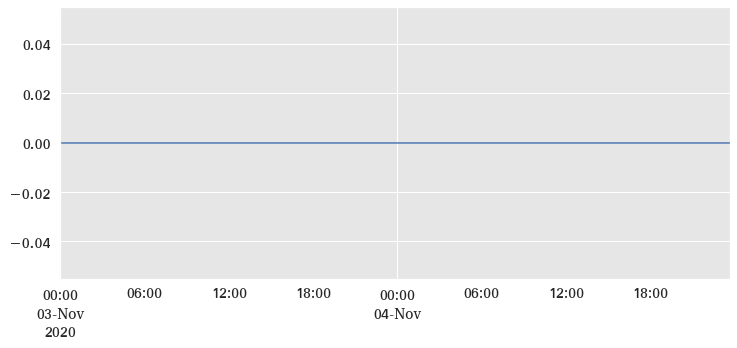

In [727]:
mpc_data['mode_1'].plot()

In [728]:
# mpc = MPC(Np=24, dt=(1/3), forecasts=mpc_data, states=states)
# start = time.time()
# results = mpc.solve()
# end = time.time()
# print(f'\nSolved in {str(round(end-start,2))}s')

In [729]:
# mpc_data = extract_pyomo_electrical_data(mpc_data.index, mpc.m, mpc_data)
# mpc_data = extract_pyomo_thermal_data(mpc_data.index, mpc.m, mpc_data)

In [730]:
# plot_electrical3(mpc_data['2020-11-26'], sim='mbc')

In [731]:
# plot_thermal_combined2(mpc_data['2020-11-26'])

In [732]:
mpc_results = pd.DataFrame(index = mpc_data.index, columns=['t_ext', 'ghi', 't_bed', 'pv', 'fixed', 'tou', 'fit', 'ch_cost',
       'dis_cost', 'mode_0', 'mode_1', 'mode_2', 'set_point', 'sp_soft',
       'heat_gains', 'load_sim', 'load1', 'heat_gains0', 'load', 'cop',
       'cool_cap', 'p_im', 'p_ex', 'p_ch', 'p_dis', 'soc', 'phi_h_heat',
       'phi_h_cool', 'p_hvac', 'T_i', 'T_w'])



In [733]:
Np = 24

In [734]:
# start = time.time()

# print(states)

# for i, idx in enumerate(mpc_data.index):
#     print('\n' + str(i) + '\n' + str(idx) + '\n')
#     mpc_sim = mpc_data.iloc[i:i+int(Np/dt)].copy()

#     mpc = MPC_DRH(Np=Np, dt=dt, forecasts=mpc_sim, states=states)
#     mpc.solve()

#     mpc_sim = extract_pyomo_electrical_data(mpc_sim.index, mpc.m, mpc_sim)
#     mpc_sim = extract_pyomo_thermal_data(mpc_sim.index, mpc.m, mpc_sim)

#     mpc_results_first_step = mpc_sim.iloc[0].copy()
#     mpc_results.iloc[i] = mpc_results_first_step
    
#     #states = {'SoC_Av':mpc_sim['soc'].iloc[0]}
    
# #     states = {'SoC_Av':mpc_sim['soc'].iloc[0],
# #               'T_i':mpc_sim['T_i'].iloc[1],
# #               'T_w':mpc_sim['T_w'].iloc[1],
# #               'phi_h':mpc_sim['phi_h_heat'].iloc[1],
# #               'phi_c':mpc_sim['phi_h_cool'].iloc[1]}
    
#     states = {'SoC_Av':mpc_sim['soc'].iloc[0],
#               'T_i':mpc_sim['T_i'].iloc[1],
#               'T_w':mpc_sim['T_w'].iloc[1],
#               'phi_c':mpc_sim['phi_h_cool'].iloc[1]}

    
#     if(i==72):
#         break 
# #     if(i==500):
# #         break
        
# end = time.time()
# print(f'\nSolved in {str(round(end-start,2))}s')

In [735]:
def sbrc_mpc_df(sb_phase):
    sbrc_pv = pd.DataFrame()
    sbrc_pv['load'] = (sbrc.loc[start:end][f'Avg{sb_phase}'] - pv.loc[start:end][f'{sb_phase}_Avg[W]'])
    sbrc_pv['pv'] = -(pv.loc[start:end][f'{sb_phase}_Avg[W]'])

    sbrc_pv = sbrc_pv.resample('20min').mean()

    for col in ['fixed', 'tou', 'fit', 'ch_cost', 'dis_cost', 'mode_0', 'mode_1']:
        sbrc_pv[col] = [ts_data[col].loc[idx]  for idx in sbrc_pv.index.time]
        
        
#     mpc_data.loc['2020-11-04','mode_0'] = 1
#     mpc_data.loc['2020-11-04','mode_1'] = 0
        
    mpc_data['mode_0'] = 1
    mpc_data['mode_1'] = 0
        
    return sbrc_pv

## Simulate MPC Each Pahse SBRC

In [736]:
mpc_results = pd.DataFrame(index = mpc_data.index, columns=['t_ext', 'ghi', 't_bed', 'pv', 'fixed', 'tou', 'fit', 'ch_cost',
       'dis_cost', 'mode_0', 'mode_1', 'mode_2', 'set_point', 'sp_soft',
       'heat_gains', 'load_sim', 'load1', 'heat_gains0', 'load', 'cop',
       'cool_cap', 'p_im', 'p_ex', 'p_ch', 'p_dis', 'soc', 'phi_h_heat',
       'phi_h_cool', 'p_hvac', 'T_i', 'T_w'])

In [737]:
states = {'SoC_Av':20}

<AxesSubplot:>

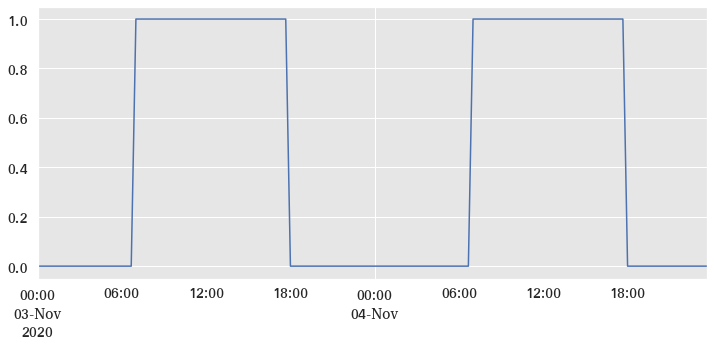

In [738]:
mpc_data = sbrc_mpc_df('P1')
mpc_data['mode_1'].plot()

In [739]:

for ph in ['P1', 'P2', 'P3']:
    
    mpc_data = sbrc_mpc_df(ph)
    
    print(states)

    
    for i, idx in enumerate(mpc_data.index):
        print('\n' + str(i) + '\n' + str(idx) + '\n')
        mpc_sim = mpc_data.iloc[i:i+int(Np/dt)].copy()
        
        mpc = MPC_SBRC(Np=Np, dt=dt, forecasts=mpc_sim, states=states)
        mpc.solve()

        mpc_sim = extract_pyomo_electrical_data(mpc_sim.index, mpc.m, mpc_sim)
#         #mpc_sim = extract_pyomo_thermal_data(mpc_sim.index, mpc.m, mpc_sim)
        
        print(mpc_sim)

        mpc_results_first_step = mpc_sim.iloc[0].copy()
        mpc_results.iloc[i] = mpc_results_first_step

        states = {'SoC_Av':mpc_sim['soc'].iloc[0]}


        if(i==72):
            break
    
    mpc_results.to_csv(f'Results/Ecomode_20min_SBRC_{ph}_3-11-2020_7am_6pm.csv')
    states = {'SoC_Av':20}
            

        

{'SoC_Av': 20}

0
2020-11-03 00:00:00

Solver log file: '/tmp/tmp83oynu5p_gurobi_ampl.log'
Solver solution file: '/tmp/tmpiwf0ni9o.pyomo.sol'
Solver problem files: ('/tmp/tmpiwf0ni9o.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 00:00:00  21988.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 00:20:00  22057.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 00:40:00  22108.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 01:00:00  22115.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 01:20:00  22077.00  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-03 22:20:00  23763.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 22:40:00  23954.00  0.0   0.25  0.1

Solver log file: '/tmp/tmpgltn6dml_gurobi_ampl.log'
Solver solution file: '/tmp/tmpschojspj.pyomo.sol'
Solver problem files: ('/tmp/tmpschojspj.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 01:20:00  22077.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 01:40:00  21859.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:00:00  22068.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:20:00  22044.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:40:00  21867.75  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-03 23:40:00  23564.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:00:00  23488.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-0

Solver log file: '/tmp/tmp3aq3rm6o_gurobi_ampl.log'
Solver solution file: '/tmp/tmp6no6_n20.pyomo.sol'
Solver problem files: ('/tmp/tmp6no6_n20.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 02:40:00  21867.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 03:00:00  22131.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 03:20:00  22090.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 03:40:00  21894.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 04:00:00  21862.25  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 01:00:00  23119.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 01:20:00  23507.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-0

Solver log file: '/tmp/tmpd7347rdx_gurobi_ampl.log'
Solver solution file: '/tmp/tmpwoa5djej.pyomo.sol'
Solver problem files: ('/tmp/tmpwoa5djej.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 04:00:00  21862.250    0.000   0.25  0.16  0.11     0.02      0.01   
2020-11-03 04:20:00  22380.500    0.000   0.25  0.16  0.11     0.02      0.01   
2020-11-03 04:40:00  22028.725   -4.525   0.25  0.16  0.11     0.02      0.01   
2020-11-03 05:00:00  22145.750  162.250   0.25  0.16  0.11     0.02      0.01   
2020-11-03 05:20:00  21832.225  986.475   0.25  0.16  0.11     0.02      0.01   
...                        ...      ...    ...   ...   ...      ...       ...   
2020-11-04 02:20:00  22818.250    0.000   0.25  0.16  0.11     0.02      0.01   
2020-11-04 02:40:00  23052.750    0.000   0.2

Solver log file: '/tmp/tmpi9c5jfa6_gurobi_ampl.log'
Solver solution file: '/tmp/tmpivp9rgq6.pyomo.sol'
Solver problem files: ('/tmp/tmpivp9rgq6.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 05:20:00  21832.225    986.475   0.25  0.16  0.11     0.02   
2020-11-03 05:40:00  21076.500   3163.500   0.25  0.16  0.11     0.02   
2020-11-03 06:00:00  20329.500   5888.250   0.25  0.28  0.11     0.02   
2020-11-03 06:20:00  20032.750   8659.750   0.25  0.28  0.11     0.02   
2020-11-03 06:40:00  22281.000  11545.000   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 03:40:00  23197.000      0.000   0.25  0.16  0.11     0.02   
2020-11-04 04:00:00  23087.750      0.000   0.25  0.16  0.11     0.02   
2020-11-04 04:20:00  23614.000      

Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 06:20:00  20032.750   8659.750   0.25  0.28  0.11     0.02   
2020-11-03 06:40:00  22281.000  11545.000   0.25  0.28  0.11     0.02   
2020-11-03 07:00:00  22205.500  14422.500   0.25  0.28  0.11     0.02   
2020-11-03 07:20:00  23635.750  16852.500   0.25  0.28  0.11     0.02   
2020-11-03 07:40:00  23688.000  19602.500   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 04:40:00  24277.050     -6.700   0.25  0.16  0.11     0.02   
2020-11-04 05:00:00  24304.175    268.925   0.25  0.16  0.11     0.02   
2020-11-04 05:20:00  23904.675   1242.425   0.25  0.16  0.11     0.02   
2020-11-04 05:40:00  22760.000   3788.500   0.25  0.16  0.11     0.02   
2020-11-04 06:00:00  22579.250   6713.750   0.25  0.28  0.11     0.02   

                     dis_cost  mode_0  mode_1          p_im  p_ex  \
2020-11-03 06:20:00      0.01       1     

Gurobi 9.0.1                         load        pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 07:20:00  23635.75  16852.50   0.25  0.28  0.11     0.02      0.01   
2020-11-03 07:40:00  23688.00  19602.50   0.25  0.28  0.11     0.02      0.01   
2020-11-03 08:00:00  19722.75  22125.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 08:20:00  16240.25  23950.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 08:40:00  16662.75  24645.00   0.25  0.28  0.11     0.02      0.01   
...                       ...       ...    ...   ...   ...      ...       ...   
2020-11-04 05:40:00  22760.00   3788.50   0.25  0.16  0.11     0.02      0.01   
2020-11-04 06:00:00  22579.25   6713.75   0.25  0.28  0.11     0.02      0.01   
2020-11-04 06:20:00  22822.50   8538.50   0.25  0.28  0.11     0.02      0.01   
2020-11-04 06:40:00  24044.75  12760.25   0.25  0.28  0.11     0.02      0.01   
2020-11-04 07:00:00  24872.00  10091.50   0.25  0.28  0.11     0.02      0.01   

               


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load        pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 08:20:00  16240.25  23950.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 08:40:00  16662.75  24645.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 09:00:00  17617.75  25782.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 09:20:00  27122.00  27277.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 09:40:00  30859.25  28327.50   0.25  0.21  0.11     0.02      0.01   
...                       ...       ...    ...   ...   ...      ...       ...   
2020-11-04 06:40:00  24044.75  12760.25   0.25  0.28  0.11     0.02      0.01   
2020-11-04 07:00:00  24872.00  10091.50   0.25  0.28  0.11     0.02      0.01   
2020-11-04 07:20:00  25209.50  14645.25   0.25  0.28  0.11     0.02      0.01   
2020-11-04 07:40:00  24704.75  15460.75

Solver log file: '/tmp/tmp9znbbpvc_gurobi_ampl.log'
Solver solution file: '/tmp/tmp2cbobrz8.pyomo.sol'
Solver problem files: ('/tmp/tmp2cbobrz8.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load        pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 09:20:00  27122.00  27277.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 09:40:00  30859.25  28327.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:00:00  31087.00  29220.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:20:00  29840.00  29800.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:40:00  25655.00  30315.00   0.25  0.21  0.11     0.02      0.01   
...                       ...       ...    ...   ...   ...      ...       ...   
2020-11-04 07:40:00  24704.75  15460.75   0.25  0.28  0.11     0.02      0.01   
2020-11-04 08:00:00  24880.50  19125.00   0.2

Solver log file: '/tmp/tmphl4ac49h_gurobi_ampl.log'
Solver solution file: '/tmp/tmpbr77m2dj.pyomo.sol'
Solver problem files: ('/tmp/tmpbr77m2dj.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 10:20:00  29840.00  29800.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:40:00  25655.00  30315.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:00:00  17406.75  30442.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:20:00  14357.25  30555.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:40:00  13586.00  30612.5   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 08:40:00  19144.75  25380.0   0.25  0.28  0.11     0.02      0.01   
2020-11-04 09:00:00  18990.50  26560.0   0.25  0.21  

Solver log file: '/tmp/tmpds93b42x_gurobi_ampl.log'
Solver solution file: '/tmp/tmpri1bez__.pyomo.sol'
Solver problem files: ('/tmp/tmpri1bez__.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 11:20:00  14357.25  30555.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:40:00  13586.00  30612.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:00:00  12459.50  30435.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:20:00  11401.00  30217.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:40:00  12478.00  29622.5   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 09:40:00  16919.75  28795.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 10:00:00  14868.00  29932.5   0.25  0.21  

Solver log file: '/tmp/tmpw228joty_gurobi_ampl.log'
Solver solution file: '/tmp/tmpg4jlw5te.pyomo.sol'
Solver problem files: ('/tmp/tmpg4jlw5te.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 12:20:00  11401.00  30217.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:40:00  12478.00  29622.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:00:00  12871.00  28777.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:20:00  12701.00  27697.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:40:00  13146.25  26490.0   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 10:40:00  16420.00  31172.5   0.25  0.21  0.11     0.02      0.01   
2020-11-04 11:00:00  17039.75  31462.5   0.25  0.21  

Solver log file: '/tmp/tmpv1ct84v0_gurobi_ampl.log'
Solver solution file: '/tmp/tmpigut47la.pyomo.sol'
Solver problem files: ('/tmp/tmpigut47la.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 13:20:00  12701.00  27697.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:40:00  13146.25  26490.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:00:00  14254.25  25062.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:20:00  14783.00  23300.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:40:00  15046.75  21427.5   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 11:40:00  13386.25  31352.5   0.25  0.21  0.11     0.02      0.01   
2020-11-04 12:00:00  12971.75  31317.5   0.25  0.21  

Solver log file: '/tmp/tmpk6kr_ic0_gurobi_ampl.log'
Solver solution file: '/tmp/tmpqoe4vjpu.pyomo.sol'
Solver problem files: ('/tmp/tmpqoe4vjpu.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 14:20:00  14783.00  23300.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:40:00  15046.75  21427.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:00:00  16737.75  19317.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:20:00  20241.50  16992.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:40:00  22625.75  14472.5   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 12:40:00  10512.75  29760.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 13:00:00   8466.00  28900.0   0.25  0.21  

Solver log file: '/tmp/tmplad73qbb_gurobi_ampl.log'
Solver solution file: '/tmp/tmp9r5p70zh.pyomo.sol'
Solver problem files: ('/tmp/tmp9r5p70zh.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load        pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 15:20:00  20241.50  16992.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:40:00  22625.75  14472.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 16:00:00  23989.00  11730.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 16:20:00  27319.00   8916.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 16:40:00  29138.00   6048.75   0.25  0.21  0.11     0.02      0.01   
...                       ...       ...    ...   ...   ...      ...       ...   
2020-11-04 13:40:00   9977.25  26582.50   0.25  0.21  0.11     0.02      0.01   
2020-11-04 14:00:00  20756.75  16172.50   0.2

Solver log file: '/tmp/tmpcg7f6nyh_gurobi_ampl.log'
Solver solution file: '/tmp/tmpmw5l_d0o.pyomo.sol'
Solver problem files: ('/tmp/tmpmw5l_d0o.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 16:20:00  27319.000   8916.500   0.25  0.21  0.11     0.02   
2020-11-03 16:40:00  29138.000   6048.750   0.25  0.21  0.11     0.02   
2020-11-03 17:00:00  28253.000   3477.500   0.25  0.28  0.11     0.02   
2020-11-03 17:20:00  24224.675   1538.425   0.25  0.28  0.11     0.02   
2020-11-03 17:40:00  24187.525    591.525   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 14:40:00  13406.750  21987.500   0.25  0.21  0.11     0.02   
2020-11-04 15:00:00  30743.250  19225.000   0.25  0.21  0.11     0.02   
2020-11-04 15:20:00  29113.500  1811


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load        pv  fixed   tou   fit  ch_cost  \
2020-11-03 17:20:00  24224.675  1538.425   0.25  0.28  0.11     0.02   
2020-11-03 17:40:00  24187.525   591.525   0.25  0.28  0.11     0.02   
2020-11-03 18:00:00  23731.325   133.325   0.25  0.28  0.11     0.02   
2020-11-03 18:20:00  24068.025  -145.975   0.25  0.28  0.11     0.02   
2020-11-03 18:40:00  24996.400   -54.100   0.25  0.28  0.11     0.02   
...                        ...       ...    ...   ...   ...      ...   
2020-11-04 15:40:00  24887.250  9644.250   0.25  0.21  0.11     0.02   
2020-11-04 16:00:00  24701.250  5531.500   0.25  0.21  0.11     0.02   
2020-11-04 16:20:00  23689.750  4307.250   0.25  0.21  0.11     0.02   
2020-11-04 16:40:00  22307.250  3659.000   0.25  0.21  0.11     0.02   
2020-11-04 17:00:00  22720.500  2600.750   0.25  0.28  0.

Solver log file: '/tmp/tmp2l8_z8xa_gurobi_ampl.log'
Solver solution file: '/tmp/tmplo08tkq1.pyomo.sol'
Solver problem files: ('/tmp/tmplo08tkq1.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 18:40:00  24996.40   -54.10   0.25  0.28  0.11     0.02      0.01   
2020-11-03 19:00:00  39518.00     0.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 19:20:00  35662.00     0.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 19:40:00  28671.00     0.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 20:00:00  27135.25     0.00   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 17:00:00  22720.50  2600.75   0.25  0.28  0.11     0.02      0.01   
2020-11-04 17:20:00  22709.75  1373.00   0.25  0.28  

Solver log file: '/tmp/tmprgpg8brq_gurobi_ampl.log'
Solver solution file: '/tmp/tmpco4nx430.pyomo.sol'
Solver problem files: ('/tmp/tmpco4nx430.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load      pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 20:00:00  27135.25    0.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 20:20:00  27274.25    0.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 20:40:00  27065.50    0.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 21:00:00  24198.00    0.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 21:20:00  23698.25    0.00   0.25  0.21  0.11     0.02      0.01   
...                       ...     ...    ...   ...   ...      ...       ...   
2020-11-04 18:20:00  24246.40 -168.35   0.25  0.28  0.11     0.02      0.01   
2020-11-04 18:40:00  21783.35  -29.40   0.25  0.28  0.11     

Solver log file: '/tmp/tmpm_jm6a3a_gurobi_ampl.log'
Solver solution file: '/tmp/tmprvt1wwg3.pyomo.sol'
Solver problem files: ('/tmp/tmprvt1wwg3.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 21:20:00  23698.25  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 21:40:00  23984.25  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 22:00:00  23502.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 22:20:00  23763.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 22:40:00  23954.00  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 19:40:00  21537.50  0.0   0.25  0.28  0.11     0.02      0.01   
2020-11-04 20:00:00  21187.75  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-0

Solver log file: '/tmp/tmphb7camab_gurobi_ampl.log'
Solver solution file: '/tmp/tmpifplelvb.pyomo.sol'
Solver problem files: ('/tmp/tmpifplelvb.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 22:40:00  23954.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:00:00  23558.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:20:00  23416.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:40:00  23564.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:00:00  23488.50  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 21:00:00  24669.25  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 21:20:00  20885.50  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-0

Solver log file: '/tmp/tmp8pt7x8m7_gurobi_ampl.log'
Solver solution file: '/tmp/tmpwx2pz6xp.pyomo.sol'
Solver problem files: ('/tmp/tmpwx2pz6xp.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-04 00:00:00  23488.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:20:00  23082.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:40:00  22919.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 01:00:00  23119.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 01:20:00  23507.00  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 22:20:00  21840.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 22:40:00  19240.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-0

Solver log file: '/tmp/tmpqbnh9_33_gurobi_ampl.log'
Solver solution file: '/tmp/tmpr2ywhf9f.pyomo.sol'
Solver problem files: ('/tmp/tmpr2ywhf9f.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 01:00:00  10818.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 01:20:00  10652.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 01:40:00  10407.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:00:00  10559.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:20:00  10594.00  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-03 23:20:00  11144.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:40:00  10948.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-0

Solver log file: '/tmp/tmpxzr1xvsp_gurobi_ampl.log'
Solver solution file: '/tmp/tmp1t8u0b2v.pyomo.sol'
Solver problem files: ('/tmp/tmp1t8u0b2v.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 02:20:00  10594.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:40:00  10412.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 03:00:00  10668.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 03:20:00  10344.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 03:40:00  10225.25  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 00:40:00  11098.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 01:00:00  11049.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-0

Solver log file: '/tmp/tmpcwtdhqb9_gurobi_ampl.log'
Solver solution file: '/tmp/tmp34dfwch8.pyomo.sol'
Solver problem files: ('/tmp/tmp34dfwch8.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 03:40:00  10225.250    0.000   0.25  0.16  0.11     0.02      0.01   
2020-11-03 04:00:00  10450.500    0.000   0.25  0.16  0.11     0.02      0.01   
2020-11-03 04:20:00  10330.250    0.000   0.25  0.16  0.11     0.02      0.01   
2020-11-03 04:40:00  10282.275   -0.475   0.25  0.16  0.11     0.02      0.01   
2020-11-03 05:00:00  10506.425  233.175   0.25  0.16  0.11     0.02      0.01   
...                        ...      ...    ...   ...   ...      ...       ...   
2020-11-04 02:00:00  10899.000    0.000   0.25  0.16  0.11     0.02      0.01   
2020-11-04 02:20:00  10992.500    0.000   0.2

Gurobi 9.0.1                          load        pv  fixed   tou   fit  ch_cost  \
2020-11-03 04:40:00  10282.275    -0.475   0.25  0.16  0.11     0.02   
2020-11-03 05:00:00  10506.425   233.175   0.25  0.16  0.11     0.02   
2020-11-03 05:20:00  10091.600  1059.350   0.25  0.16  0.11     0.02   
2020-11-03 05:40:00   9809.250  3239.750   0.25  0.16  0.11     0.02   
2020-11-03 06:00:00  10521.250  5959.750   0.25  0.28  0.11     0.02   
...                        ...       ...    ...   ...   ...      ...   
2020-11-04 03:00:00  11254.250     0.000   0.25  0.16  0.11     0.02   
2020-11-04 03:20:00  10682.500     0.000   0.25  0.16  0.11     0.02   
2020-11-04 03:40:00  10700.750     0.000   0.25  0.16  0.11     0.02   
2020-11-04 04:00:00  11062.500     0.000   0.25  0.16  0.11     0.02   
2020-11-04 04:20:00  11111.250     0.000   0.25  0.16  0.11     0.02   

                     dis_cost  mode_0  mode_1      p_im  p_ex  p_ch   p_dis  \
2020-11-03 04:40:00      0.01       1       

Solver log file: '/tmp/tmp3ib3z1md_gurobi_ampl.log'
Solver solution file: '/tmp/tmp80fjvikn.pyomo.sol'
Solver problem files: ('/tmp/tmp80fjvikn.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 06:00:00  10521.250   5959.750   0.25  0.28  0.11     0.02   
2020-11-03 06:20:00   9853.250   8733.250   0.25  0.28  0.11     0.02   
2020-11-03 06:40:00  12179.750  11625.000   0.25  0.28  0.11     0.02   
2020-11-03 07:00:00  13083.000  14490.000   0.25  0.28  0.11     0.02   
2020-11-03 07:20:00  18632.750  16897.500   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 04:20:00  11111.250      0.000   0.25  0.16  0.11     0.02   
2020-11-04 04:40:00  11448.050     12.800   0.25  0.16  0.11     0.02   
2020-11-04 05:00:00  10960.925    34

Solver log file: '/tmp/tmpcvsf8pw0_gurobi_ampl.log'
Solver solution file: '/tmp/tmptm1sf0yq.pyomo.sol'
Solver problem files: ('/tmp/tmptm1sf0yq.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 07:00:00  13083.000  14490.000   0.25  0.28  0.11     0.02   
2020-11-03 07:20:00  18632.750  16897.500   0.25  0.28  0.11     0.02   
2020-11-03 07:40:00  20006.500  19627.500   0.25  0.28  0.11     0.02   
2020-11-03 08:00:00  17911.250  22137.500   0.25  0.28  0.11     0.02   
2020-11-03 08:20:00  15283.750  23962.500   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 05:20:00  11529.925   1316.925   0.25  0.16  0.11     0.02   
2020-11-04 05:40:00  10698.250   3871.750   0.25  0.16  0.11     0.02   
2020-11-04 06:00:00  10761.500   679

Solver log file: '/tmp/tmpitx4_uge_gurobi_ampl.log'
Solver solution file: '/tmp/tmpypooart6.pyomo.sol'
Solver problem files: ('/tmp/tmpypooart6.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load        pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 08:00:00  17911.25  22137.50   0.25  0.28  0.11     0.02      0.01   
2020-11-03 08:20:00  15283.75  23962.50   0.25  0.28  0.11     0.02      0.01   
2020-11-03 08:40:00  15647.75  24642.50   0.25  0.28  0.11     0.02      0.01   
2020-11-03 09:00:00  15846.50  25800.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 09:20:00  26441.50  27282.50   0.25  0.21  0.11     0.02      0.01   
...                       ...       ...    ...   ...   ...      ...       ...   
2020-11-04 06:20:00  10579.75   8628.75   0.25  0.28  0.11     0.02      0.01   
2020-11-04 06:40:00  12392.00  12863.50   0.2

Solver log file: '/tmp/tmpifau5p_6_gurobi_ampl.log'
Solver solution file: '/tmp/tmpws5ajsvt.pyomo.sol'
Solver problem files: ('/tmp/tmpws5ajsvt.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load        pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 09:00:00  15846.50  25800.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 09:20:00  26441.50  27282.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 09:40:00  30888.50  28337.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:00:00  31850.00  29207.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:20:00  29647.00  29802.50   0.25  0.21  0.11     0.02      0.01   
...                       ...       ...    ...   ...   ...      ...       ...   
2020-11-04 07:20:00  15045.75  14739.50   0.25  0.28  0.11     0.02      0.01   
2020-11-04 07:40:00  14486.50  15572.75   0.2

Solver log file: '/tmp/tmpf2a2_lfe_gurobi_ampl.log'
Solver solution file: '/tmp/tmpf8wly87e.pyomo.sol'
Solver problem files: ('/tmp/tmpf8wly87e.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 10:00:00  31850.00  29207.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:20:00  29647.00  29802.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:40:00  25588.50  30332.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:00:00  17618.25  30462.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:20:00  15776.50  30535.0   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 08:20:00  12266.50  23777.5   0.25  0.28  0.11     0.02      0.01   
2020-11-04 08:40:00  10007.25  25472.5   0.25  0.28  

Solver log file: '/tmp/tmpx73m7pmu_gurobi_ampl.log'
Solver solution file: '/tmp/tmplgrxsbln.pyomo.sol'
Solver problem files: ('/tmp/tmplgrxsbln.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 11:00:00  17618.25  30462.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:20:00  15776.50  30535.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:40:00  13206.00  30597.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:00:00  11686.25  30450.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:20:00  11195.25  30227.5   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 09:20:00   9458.00  27810.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 09:40:00   8226.50  28920.0   0.25  0.21  

Solver log file: '/tmp/tmpcptxbyqv_gurobi_ampl.log'
Solver solution file: '/tmp/tmpxz7pcogc.pyomo.sol'
Solver problem files: ('/tmp/tmpxz7pcogc.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 12:00:00  11686.25  30450.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:20:00  11195.25  30227.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:40:00   9540.25  29655.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:00:00  10131.00  28805.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:20:00   9904.75  27732.5   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 10:20:00   9376.75  30870.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 10:40:00  10003.25  31285.0   0.25  0.21  

Solver log file: '/tmp/tmp2kaikfoo_gurobi_ampl.log'
Solver solution file: '/tmp/tmp53yow0xi.pyomo.sol'
Solver problem files: ('/tmp/tmp53yow0xi.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 13:00:00  10131.00  28805.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:20:00   9904.75  27732.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:40:00   8515.25  26542.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:00:00   8727.25  25145.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:20:00   8563.50  23387.5   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 11:20:00   9534.75  31950.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 11:40:00   8815.25  31442.5   0.25  0.21  

Solver log file: '/tmp/tmpcyi3n4d0_gurobi_ampl.log'
Solver solution file: '/tmp/tmpy3p65pfr.pyomo.sol'
Solver problem files: ('/tmp/tmpy3p65pfr.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 14:00:00   8727.25  25145.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:20:00   8563.50  23387.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:40:00   9067.00  21537.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:00:00  10338.50  19447.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:20:00  13197.75  17110.0   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 12:20:00   6452.75  30937.5   0.25  0.21  0.11     0.02      0.01   
2020-11-04 12:40:00   5024.25  29850.0   0.25  0.21  

Solver log file: '/tmp/tmpzdjfmrya_gurobi_ampl.log'
Solver solution file: '/tmp/tmpic_agogy.pyomo.sol'
Solver problem files: ('/tmp/tmpic_agogy.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 15:00:00  10338.50  19447.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:20:00  13197.75  17110.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:40:00  12510.75  14590.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 16:00:00  13414.75  11825.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 16:20:00  15780.00   9001.0   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 13:20:00   5787.25  28002.5   0.25  0.21  0.11     0.02      0.01   
2020-11-04 13:40:00   4394.25  26650.0   0.25  0.21  

Solver log file: '/tmp/tmpoeq0izga_gurobi_ampl.log'
Solver solution file: '/tmp/tmp4n43uohb.pyomo.sol'
Solver problem files: ('/tmp/tmp4n43uohb.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 16:00:00  13414.750  11825.000   0.25  0.21  0.11     0.02   
2020-11-03 16:20:00  15780.000   9001.000   0.25  0.21  0.11     0.02   
2020-11-03 16:40:00  16226.500   6126.750   0.25  0.21  0.11     0.02   
2020-11-03 17:00:00  14516.250   3552.750   0.25  0.28  0.11     0.02   
2020-11-03 17:20:00  11350.975   1609.975   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 14:20:00   4784.000  22637.500   0.25  0.21  0.11     0.02   
2020-11-04 14:40:00   7547.000  22040.000   0.25  0.21  0.11     0.02   
2020-11-04 15:00:00  22753.250  1929

Solver log file: '/tmp/tmprjb9o6g1_gurobi_ampl.log'
Solver solution file: '/tmp/tmpbvotm2av.pyomo.sol'
Solver problem files: ('/tmp/tmpbvotm2av.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 17:00:00  14516.250   3552.750   0.25  0.28  0.11     0.02   
2020-11-03 17:20:00  11350.975   1609.975   0.25  0.28  0.11     0.02   
2020-11-03 17:40:00  10619.800    665.300   0.25  0.28  0.11     0.02   
2020-11-03 18:00:00  10556.550    208.050   0.25  0.28  0.11     0.02   
2020-11-03 18:20:00  10986.850    -69.650   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 15:20:00  21845.000  18162.500   0.25  0.21  0.11     0.02   
2020-11-04 15:40:00  14429.750   9701.500   0.25  0.21  0.11     0.02   
2020-11-04 16:00:00  13207.250   560

Gurobi 9.0.1                          load        pv  fixed   tou   fit  ch_cost  \
2020-11-03 18:00:00  10556.550   208.050   0.25  0.28  0.11     0.02   
2020-11-03 18:20:00  10986.850   -69.650   0.25  0.28  0.11     0.02   
2020-11-03 18:40:00  11246.925   -33.075   0.25  0.28  0.11     0.02   
2020-11-03 19:00:00  25592.500     0.000   0.25  0.28  0.11     0.02   
2020-11-03 19:20:00  22610.250     0.000   0.25  0.28  0.11     0.02   
...                        ...       ...    ...   ...   ...      ...   
2020-11-04 16:20:00  10155.500  4380.250   0.25  0.21  0.11     0.02   
2020-11-04 16:40:00   8511.000  3728.000   0.25  0.21  0.11     0.02   
2020-11-04 17:00:00   9643.500  2667.500   0.25  0.28  0.11     0.02   
2020-11-04 17:20:00   9529.275  1443.525   0.25  0.28  0.11     0.02   
2020-11-04 17:40:00   9445.050   595.300   0.25  0.28  0.11     0.02   

                     dis_cost  mode_0  mode_1      p_im  p_ex  p_ch    p_dis  \
2020-11-03 18:00:00      0.01       1      

Solver log file: '/tmp/tmpvqvmia7z_gurobi_ampl.log'
Solver solution file: '/tmp/tmpefyo0sji.pyomo.sol'
Solver problem files: ('/tmp/tmpefyo0sji.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 19:20:00  22610.250    0.000   0.25  0.28  0.11     0.02      0.01   
2020-11-03 19:40:00  16025.750    0.000   0.25  0.28  0.11     0.02      0.01   
2020-11-03 20:00:00  14273.250    0.000   0.25  0.21  0.11     0.02      0.01   
2020-11-03 20:20:00  14726.750    0.000   0.25  0.21  0.11     0.02      0.01   
2020-11-03 20:40:00  13532.750    0.000   0.25  0.21  0.11     0.02      0.01   
...                        ...      ...    ...   ...   ...      ...       ...   
2020-11-04 17:40:00   9445.050  595.300   0.25  0.28  0.11     0.02      0.01   
2020-11-04 18:00:00   8847.925  240.675   0.2

Solver log file: '/tmp/tmpkd9g4jx5_gurobi_ampl.log'
Solver solution file: '/tmp/tmp2ppl9__7.pyomo.sol'
Solver problem files: ('/tmp/tmp2ppl9__7.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 20:40:00  13532.75  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 21:00:00  11457.50  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 21:20:00  11227.00  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 21:40:00  11191.00  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 22:00:00  10659.75  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 19:00:00  11064.25  0.0   0.25  0.28  0.11     0.02      0.01   
2020-11-04 19:20:00  10599.00  0.0   0.25  0.28  0.11     0.02      0.01   
2020-11-0


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 21:40:00  11191.00  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 22:00:00  10659.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 22:20:00  10579.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 22:40:00  10928.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:00:00  11059.75  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 20:00:00   8589.00  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 20:20:00  10801.50  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 20:40:00   7960.50  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 21:00:00  11542.75  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 21

Solver log file: '/tmp/tmpov9l4rg__gurobi_ampl.log'
Solver solution file: '/tmp/tmp71_ja_e9.pyomo.sol'
Solver problem files: ('/tmp/tmp71_ja_e9.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 23:00:00  11059.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:20:00  11144.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:40:00  10948.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:00:00  10659.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:20:00  10982.75  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 21:20:00   7629.75  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 21:40:00   8786.00  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-0

{'SoC_Av': 20}

0
2020-11-03 00:00:00

Solver log file: '/tmp/tmpm2ga3t_t_gurobi_ampl.log'
Solver solution file: '/tmp/tmppaj3idhn.pyomo.sol'
Solver problem files: ('/tmp/tmppaj3idhn.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 00:00:00  15574.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 00:20:00  15709.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 00:40:00  15684.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 01:00:00  15715.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 01:20:00  15630.50  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-03 22:20:00  15987.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 22:40:00  16225.75  0.0   0.25  0.1

Solver log file: '/tmp/tmp802nr0bk_gurobi_ampl.log'
Solver solution file: '/tmp/tmpk1t1gdra.pyomo.sol'
Solver problem files: ('/tmp/tmpk1t1gdra.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 01:20:00  15630.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 01:40:00  15415.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:00:00  15611.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:20:00  15635.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:40:00  15594.25  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-03 23:40:00  16362.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:00:00  16133.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-0

Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 02:20:00  15635.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 02:40:00  15594.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 03:00:00  18682.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 03:20:00  15517.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 03:40:00  16241.75  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 00:40:00  16352.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 01:00:00  16536.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 01:20:00  17210.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 01:40:00  19847.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 02:00:00  16690.25  0.0   0.25  0.16  0.11     0.02      0.01   

                     mode_0  mode_1          p_im  p_ex         p_ch  p_dis

Solver log file: '/tmp/tmpvspj6hqq_gurobi_ampl.log'
Solver solution file: '/tmp/tmpw8ja2pqk.pyomo.sol'
Solver problem files: ('/tmp/tmpw8ja2pqk.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load      pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 03:40:00  16241.75    0.00   0.25  0.16  0.11     0.02      0.01   
2020-11-03 04:00:00  17099.25    0.00   0.25  0.16  0.11     0.02      0.01   
2020-11-03 04:20:00  15444.75    0.00   0.25  0.16  0.11     0.02      0.01   
2020-11-03 04:40:00  15427.00    1.00   0.25  0.16  0.11     0.02      0.01   
2020-11-03 05:00:00  15800.35  274.85   0.25  0.16  0.11     0.02      0.01   
...                       ...     ...    ...   ...   ...      ...       ...   
2020-11-04 02:00:00  16690.25    0.00   0.25  0.16  0.11     0.02      0.01   
2020-11-04 02:20:00  16302.75    0.00   0.25  0.16  0.11     


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load        pv  fixed   tou   fit  ch_cost  \
2020-11-03 04:40:00  15427.000     1.000   0.25  0.16  0.11     0.02   
2020-11-03 05:00:00  15800.350   274.850   0.25  0.16  0.11     0.02   
2020-11-03 05:20:00  15062.675  1104.675   0.25  0.16  0.11     0.02   
2020-11-03 05:40:00  14432.000  3280.000   0.25  0.16  0.11     0.02   
2020-11-03 06:00:00  14032.250  6005.250   0.25  0.28  0.11     0.02   
...                        ...       ...    ...   ...   ...      ...   
2020-11-04 03:00:00  16588.250     0.000   0.25  0.16  0.11     0.02   
2020-11-04 03:20:00  16086.750     0.000   0.25  0.16  0.11     0.02   
2020-11-04 03:40:00  16174.750     0.000   0.25  0.16  0.11     0.02   
2020-11-04 04:00:00  16300.750     0.000   0.25  0.16  0.11     0.02   
2020-11-04 04:20:00  16317.000     0.000   0.25  0.16  0.


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 05:40:00  14432.000   3280.000   0.25  0.16  0.11     0.02   
2020-11-03 06:00:00  14032.250   6005.250   0.25  0.28  0.11     0.02   
2020-11-03 06:20:00  13477.000   8775.250   0.25  0.28  0.11     0.02   
2020-11-03 06:40:00  15323.750  11657.500   0.25  0.28  0.11     0.02   
2020-11-03 07:00:00  15404.750  14525.000   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 04:00:00  16300.750      0.000   0.25  0.16  0.11     0.02   
2020-11-04 04:20:00  16317.000      0.000   0.25  0.16  0.11     0.02   
2020-11-04 04:40:00  16729.650     23.650   0.25  0.16  0.11     0.02   
2020-11-04 05:00:00  16353.250    390.500   0.25  0.16  0.11     0.02   
2020-11-04 05:20:00  15916.525   1362.775   0.

Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 06:40:00  15323.750  11657.500   0.25  0.28  0.11     0.02   
2020-11-03 07:00:00  15404.750  14525.000   0.25  0.28  0.11     0.02   
2020-11-03 07:20:00  18131.000  16950.000   0.25  0.28  0.11     0.02   
2020-11-03 07:40:00  18864.250  19690.000   0.25  0.28  0.11     0.02   
2020-11-03 08:00:00  15678.000  22187.500   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 05:00:00  16353.250    390.500   0.25  0.16  0.11     0.02   
2020-11-04 05:20:00  15916.525   1362.775   0.25  0.16  0.11     0.02   
2020-11-04 05:40:00  15429.250   3915.000   0.25  0.16  0.11     0.02   
2020-11-04 06:00:00  14961.000   6842.250   0.25  0.28  0.11     0.02   
2020-11-04 06:20:00  14569.250   8671.750   0.25  0.28  0.11     0.02   

                     dis_cost  mode_0  mode_1          p_im     p_ex    p_ch  \
2020-11-03 06:40:00      0.01  

Solver log file: '/tmp/tmpy_8ltk4h_gurobi_ampl.log'
Solver solution file: '/tmp/tmpa2d2jb0n.pyomo.sol'
Solver problem files: ('/tmp/tmpa2d2jb0n.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load        pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 07:40:00  18864.25  19690.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 08:00:00  15678.00  22187.50   0.25  0.28  0.11     0.02      0.01   
2020-11-03 08:20:00  12075.25  24007.50   0.25  0.28  0.11     0.02      0.01   
2020-11-03 08:40:00  12330.25  24695.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 09:00:00  12234.25  25817.50   0.25  0.21  0.11     0.02      0.01   
...                       ...       ...    ...   ...   ...      ...       ...   
2020-11-04 06:00:00  14961.00   6842.25   0.25  0.28  0.11     0.02      0.01   
2020-11-04 06:20:00  14569.25   8671.75   0.2

Solver log file: '/tmp/tmp14_ft4d2_gurobi_ampl.log'
Solver solution file: '/tmp/tmpt97oucrq.pyomo.sol'
Solver problem files: ('/tmp/tmpt97oucrq.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load        pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 08:40:00  12330.25  24695.00   0.25  0.28  0.11     0.02      0.01   
2020-11-03 09:00:00  12234.25  25817.50   0.25  0.21  0.11     0.02      0.01   
2020-11-03 09:20:00  24642.00  27325.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 09:40:00  25842.50  28365.00   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:00:00  26612.00  29270.00   0.25  0.21  0.11     0.02      0.01   
...                       ...       ...    ...   ...   ...      ...       ...   
2020-11-04 07:00:00  17114.75  10218.75   0.25  0.28  0.11     0.02      0.01   
2020-11-04 07:20:00  18068.00  14780.25   0.2

Solver log file: '/tmp/tmp2zj8iowa_gurobi_ampl.log'
Solver solution file: '/tmp/tmpizp4pjab.pyomo.sol'
Solver problem files: ('/tmp/tmpizp4pjab.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 09:40:00  25842.50  28365.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:00:00  26612.00  29270.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:20:00  24818.50  29837.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 10:40:00  21126.25  30357.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:00:00  12415.50  30495.0   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 08:00:00  15855.00  19217.5   0.25  0.28  0.11     0.02      0.01   
2020-11-04 08:20:00  12299.00  23760.0   0.25  0.28  

Solver log file: '/tmp/tmp_ide9a2r_gurobi_ampl.log'
Solver solution file: '/tmp/tmp_1_iz2e9.pyomo.sol'
Solver problem files: ('/tmp/tmp_1_iz2e9.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 10:40:00  21126.25  30357.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:00:00  12415.50  30495.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:20:00   9915.25  30585.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 11:40:00   7960.00  30642.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:00:00   6900.50  30492.5   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 09:00:00   8833.50  26650.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 09:20:00   7766.25  27780.0   0.25  0.21  

Solver log file: '/tmp/tmpl44oi8ml_gurobi_ampl.log'
Solver solution file: '/tmp/tmpe0jqt6im.pyomo.sol'
Solver problem files: ('/tmp/tmpe0jqt6im.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                        load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 11:40:00  7960.00  30642.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:00:00  6900.50  30492.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:20:00  7326.75  30277.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 12:40:00  7735.25  29670.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:00:00  7130.25  28832.5   0.25  0.21  0.11     0.02      0.01   
...                      ...      ...    ...   ...   ...      ...       ...   
2020-11-04 10:00:00  7543.25  30027.5   0.25  0.21  0.11     0.02      0.01   
2020-11-04 10:20:00  8606.25  30842.5   0.25  0.21  0.11     

Solver log file: '/tmp/tmpg27xs3x8_gurobi_ampl.log'
Solver solution file: '/tmp/tmps8qfmm7c.pyomo.sol'
Solver problem files: ('/tmp/tmps8qfmm7c.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                        load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 12:40:00  7735.25  29670.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:00:00  7130.25  28832.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:20:00  7142.75  27750.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 13:40:00  7620.50  26577.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:00:00  8319.00  25192.5   0.25  0.21  0.11     0.02      0.01   
...                      ...      ...    ...   ...   ...      ...       ...   
2020-11-04 11:00:00  9204.75  31577.5   0.25  0.21  0.11     0.02      0.01   
2020-11-04 11:20:00  8651.00  31942.5   0.25  0.21  0.11     

Solver log file: '/tmp/tmpw4qku1b1_gurobi_ampl.log'
Solver solution file: '/tmp/tmpom92pnlu.pyomo.sol'
Solver problem files: ('/tmp/tmpom92pnlu.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 13:40:00   7620.50  26577.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:00:00   8319.00  25192.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:20:00   8297.25  23392.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 14:40:00   9124.00  21550.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:00:00  10549.50  19462.5   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 12:00:00   7059.50  31390.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 12:20:00   2299.75  30862.5   0.25  0.21  

Solver log file: '/tmp/tmpyz3efbda_gurobi_ampl.log'
Solver solution file: '/tmp/tmpe1599az_.pyomo.sol'
Solver problem files: ('/tmp/tmpe1599az_.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 14:40:00   9124.00  21550.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:00:00  10549.50  19462.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:20:00  13126.75  17152.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 15:40:00  15023.25  14610.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 16:00:00  16629.75  11860.0   0.25  0.21  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 13:00:00   2421.50  28987.5   0.25  0.21  0.11     0.02      0.01   
2020-11-04 13:20:00   5143.50  28050.0   0.25  0.21  

Solver log file: '/tmp/tmp6qp9d4x0_gurobi_ampl.log'
Solver solution file: '/tmp/tmpc9z6zu0t.pyomo.sol'
Solver problem files: ('/tmp/tmpc9z6zu0t.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load       pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 15:40:00  15023.25  14610.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 16:00:00  16629.75  11860.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 16:20:00  21736.75   9054.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 16:40:00  21244.00   6169.5   0.25  0.21  0.11     0.02      0.01   
2020-11-03 17:00:00  19155.00   3591.5   0.25  0.28  0.11     0.02      0.01   
...                       ...      ...    ...   ...   ...      ...       ...   
2020-11-04 14:00:00  12459.00  16280.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 14:20:00   4474.75  22672.5   0.25  0.21  

Solver log file: '/tmp/tmp806bm3cn_gurobi_ampl.log'
Solver solution file: '/tmp/tmpb73wv8et.pyomo.sol'
Solver problem files: ('/tmp/tmpb73wv8et.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load         pv  fixed   tou   fit  ch_cost  \
2020-11-03 16:40:00  21244.000   6169.500   0.25  0.21  0.11     0.02   
2020-11-03 17:00:00  19155.000   3591.500   0.25  0.28  0.11     0.02   
2020-11-03 17:20:00  16012.250   1648.750   0.25  0.28  0.11     0.02   
2020-11-03 17:40:00  16063.125    703.625   0.25  0.28  0.11     0.02   
2020-11-03 18:00:00  16236.300    244.800   0.25  0.28  0.11     0.02   
...                        ...        ...    ...   ...   ...      ...   
2020-11-04 15:00:00  22908.750  19330.000   0.25  0.21  0.11     0.02   
2020-11-04 15:20:00  23137.750  18200.000   0.25  0.21  0.11     0.02   
2020-11-04 15:40:00  17739.750   975

Gurobi 9.0.1                          load        pv  fixed   tou   fit  ch_cost  \
2020-11-03 17:40:00  16063.125   703.625   0.25  0.28  0.11     0.02   
2020-11-03 18:00:00  16236.300   244.800   0.25  0.28  0.11     0.02   
2020-11-03 18:20:00  16917.225   -32.525   0.25  0.28  0.11     0.02   
2020-11-03 18:40:00  20061.800   -23.450   0.25  0.28  0.11     0.02   
2020-11-03 19:00:00  31579.750     0.000   0.25  0.28  0.11     0.02   
...                        ...       ...    ...   ...   ...      ...   
2020-11-04 16:00:00  17946.750  5651.000   0.25  0.21  0.11     0.02   
2020-11-04 16:20:00  15397.000  4421.250   0.25  0.21  0.11     0.02   
2020-11-04 16:40:00  12885.250  3768.250   0.25  0.21  0.11     0.02   
2020-11-04 17:00:00  13686.250  2704.000   0.25  0.28  0.11     0.02   
2020-11-04 17:20:00  14288.525  1477.525   0.25  0.28  0.11     0.02   

                     dis_cost  mode_0  mode_1      p_im  p_ex  p_ch   p_dis  \
2020-11-03 17:40:00      0.01       0       

Solver log file: '/tmp/tmpawu80h2j_gurobi_ampl.log'
Solver solution file: '/tmp/tmp8eluitb8.pyomo.sol'
Solver problem files: ('/tmp/tmp8eluitb8.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load        pv  fixed   tou   fit  ch_cost  \
2020-11-03 19:00:00  31579.750     0.000   0.25  0.28  0.11     0.02   
2020-11-03 19:20:00  28592.000     0.000   0.25  0.28  0.11     0.02   
2020-11-03 19:40:00  21946.750     0.000   0.25  0.28  0.11     0.02   
2020-11-03 20:00:00  20096.500     0.000   0.25  0.21  0.11     0.02   
2020-11-03 20:20:00  19460.500     0.000   0.25  0.21  0.11     0.02   
...                        ...       ...    ...   ...   ...      ...   
2020-11-04 17:20:00  14288.525  1477.525   0.25  0.28  0.11     0.02   
2020-11-04 17:40:00  14056.300   631.300   0.25  0.28  0.11     0.02   
2020-11-04 18:00:00  13695.600   275.600   0.

Solver log file: '/tmp/tmpt6cbwqke_gurobi_ampl.log'
Solver solution file: '/tmp/tmp1z_gvlb7.pyomo.sol'
Solver problem files: ('/tmp/tmp1z_gvlb7.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                          load      pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 20:20:00  19460.500   0.000   0.25  0.21  0.11     0.02      0.01   
2020-11-03 20:40:00  19230.000   0.000   0.25  0.21  0.11     0.02      0.01   
2020-11-03 21:00:00  16556.000   0.000   0.25  0.21  0.11     0.02      0.01   
2020-11-03 21:20:00  16347.250   0.000   0.25  0.21  0.11     0.02      0.01   
2020-11-03 21:40:00  16582.250   0.000   0.25  0.21  0.11     0.02      0.01   
...                        ...     ...    ...   ...   ...      ...       ...   
2020-11-04 18:40:00  13614.825 -13.175   0.25  0.28  0.11     0.02      0.01   
2020-11-04 19:00:00  15651.000   0.000   0.25  0.28  

Solver log file: '/tmp/tmphna6y32a_gurobi_ampl.log'
Solver solution file: '/tmp/tmpcttaj6ty.pyomo.sol'
Solver problem files: ('/tmp/tmpcttaj6ty.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 21:40:00  16582.25  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-03 22:00:00  16166.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 22:20:00  15987.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 22:40:00  16225.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:00:00  16389.25  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 20:00:00  13967.75  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 20:20:00  15601.50  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-0

Solver log file: '/tmp/tmpg_g63xa8_gurobi_ampl.log'
Solver solution file: '/tmp/tmprpsk1c4o.pyomo.sol'
Solver problem files: ('/tmp/tmprpsk1c4o.pyomo.nl',)

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-03 23:00:00  16389.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:20:00  16589.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-03 23:40:00  16362.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:00:00  16133.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:20:00  16295.75  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 21:20:00  15763.50  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-04 21:40:00  13925.25  0.0   0.25  0.21  0.11     0.02      0.01   
2020-11-0


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Gurobi 9.0.1                         load   pv  fixed   tou   fit  ch_cost  dis_cost  \
2020-11-04 00:00:00  16133.25  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:20:00  16295.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 00:40:00  16352.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 01:00:00  16536.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 01:20:00  17210.00  0.0   0.25  0.16  0.11     0.02      0.01   
...                       ...  ...    ...   ...   ...      ...       ...   
2020-11-04 22:20:00  14431.00  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 22:40:00  12757.50  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 23:00:00  18085.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 23:20:00  12386.75  0.0   0.25  0.16  0.11     0.02      0.01   
2020-11-04 23

<AxesSubplot:>

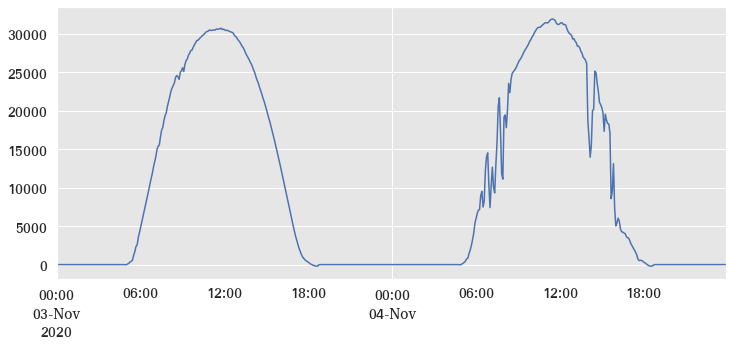

In [740]:
sbrc_pv['pv'].plot()

In [741]:
# plot_electrical3(mpc_results['2020-11-03'], sim='mbc')

In [742]:
# plot_thermal_combined2(mpc_results['2020-11-03'])

In [743]:
#mpc_results.to_csv(f'Results/Ecomode_20min_{sim}_3-11-2020_7am_6pm.csv')